# Well and Grace Drought Analysis Code
Written by Danielle Tadych

 The purpose of this script is to analyze our master water level database and GRACE data for various types of drought. 

## Loading packages and files

In [1]:
import Custom_functions as cf
from optparse import Values
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import datetime
from matplotlib.transforms import Bbox
import numpy as np
import pandas as pd
from shapely.geometry import box
import geopandas as gp
#import earthpy as et
import scipy.stats as sp
from scipy.stats import kendalltau, pearsonr, spearmanr
import pymannkendall as mk

# Data paths
datapath = '../Data/Input_files/'
outputpath = '../Data/Output_files/'
shapepath = '../Data/Shapefiles/'
figurepath = '../Data/Figures/'

In [2]:
# %%  ==== Reading in the data ====
filename_georeg = 'georeg_reproject_fixed.shp'
filepath = os.path.join(shapepath, filename_georeg)
georeg = gp.read_file(filepath)
# georeg.plot(cmap='viridis')

georeg['GEOREGI_NU'] = georeg['GEOREGI_NU'].astype('int64')
georeg.info()

# Read in the annual time series database
filename_ts = 'Wells55_GWSI_WLTS_DB_annual.csv'
filepath = os.path.join(datapath, filename_ts)
print(filepath)
annual_db = pd.read_csv(filepath, header=1, index_col=0)

annual_db.index.astype('int64')
annual_db2 = annual_db.reset_index(inplace=True)
annual_db2 = annual_db.rename(columns = {'year':'Combo_ID'})
annual_db2.head()

# For regulation
filepath = datapath+'Waterlevels_Regulation.csv'
cat_wl2_reg = pd.read_csv(filepath, index_col=0)
cat_wl2_reg.head()

# For Access to SW
filepath = datapath+'Waterlevels_AccesstoSW.csv'
cat_wl2_SW = pd.read_csv(filepath, index_col=0)
cat_wl2_SW.head()

# For georegion number
filepath = datapath+'Waterlevels_georegions.csv'
cat_wl2_georeg = pd.read_csv(filepath, index_col=0)

# Read in the drought indices
drought_indices = pd.read_csv(datapath+'Yearly_DroughtIndices.csv')
drought_indices = drought_indices.set_index('In_year')
# drought_indices

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEO_Region  11 non-null     object  
 1   GEOREGI_NU  11 non-null     int64   
 2   Water_CAT   11 non-null     object  
 3   Loc         11 non-null     object  
 4   Regulation  11 non-null     object  
 5   geometry    11 non-null     geometry
dtypes: geometry(1), int64(1), object(4)
memory usage: 656.0+ bytes
../Data/Input_files/Wells55_GWSI_WLTS_DB_annual.csv


In [3]:
# %% Creating colors
c_1 = '#8d5a99' # Reservation
c_2 = "#d7191c" # Regulated with CAP (Water Category Color)
c_3 = '#e77a47' # Regulated without CAP (Water Category Color)
c_4 = '#2cbe21' # Lower CO River - SW (Water Category Color)
c_5 = '#2f8c73' # Upper CO River - Mixed (Water Category Color)
c_6 = '#6db7e8' # SE - GW
c_7 = '#165782' # NW - GW (Water Category color)
c_8 = '#229ce8' # SC - GW
c_9 = '#1f78b4' # NE - GW
c_10 = '#41bf9e' # N - Mixed
c_11 = '#7adec4' # C - Mixed
drought_color = '#ffa6b8'
wet_color = '#b8d3f2'

reg_colors = [c_2,c_7]
georeg_colors = [c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11]
SW_colors = [c_2,c_3,c_4,c_5,c_7]

bar_watercatc = [c_2,c_3,c_4,c_5,c_7]


# Color blind palette
# https://jacksonlab.agronomy.wisc.edu/2016/05/23/15-level-colorblind-friendly-palette/
blind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

# Matching new map

cap = '#C6652B'
# noCAP = '#EDE461' # This is one from the map
noCAP = '#CCC339' # This color but darker for lines
GWdom = '#3B76AF'
mixed = '#6EB2E4'
swdom = '#469B76'

## Analysis
Wanting to look at 
1) Maximum Drawdown compared to the trend 
2) Anomalies 
3) Recovery

Decided from the drought indices analysis that the cutoff value is -3 for severe droughts


In [4]:
# %% Drought dictionary
DROUGHT_YEARS = {1:[1989,1990]
        ,2:[1996]
        ,3:[2002,2003]
        ,4:[2006,2007]
        ,5:[2012,2013,2014]
        ,6:[2018]}

print(DROUGHT_YEARS)

{1: [1989, 1990], 2: [1996], 3: [2002, 2003], 4: [2006, 2007], 5: [2012, 2013, 2014], 6: [2018]}


In [5]:
#%% Pre-drought
# PREDROUGHT_YEARS = {1:[1988]
#         ,2:[1995]
#         ,3:[2001]
#         ,4:[2005]
#         ,5:[2011]
#         ,6:[2017]}

PREDROUGHT_YEARS = {1:[*range(1975,1988,1)]
        ,2:[*range(1991,1995,1)]
        ,3:[*range(1997,2001,1)]
        ,4:[*range(2004,2005,1)]
        ,5:[*range(2006,2011,1)]
        ,6:[*range(2015,2017,1)]}

print(PREDROUGHT_YEARS)

{1: [1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987], 2: [1991, 1992, 1993, 1994], 3: [1997, 1998, 1999, 2000], 4: [2004], 5: [2006, 2007, 2008, 2009, 2010], 6: [2015, 2016]}


In [6]:
#%% Print the average PDSI and PHDI values

ds = drought_indices.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


pdsi_avg = ds.groupby(['Status']).mean()
pdsi_avg

PDSI      PHDI
Status                        
Drought 1  -2.281250 -2.974167
Drought 2  -4.137500 -4.137500
Drought 3  -4.109167 -4.109167
Drought 4  -3.658750 -3.658750
Drought 5  -3.164722 -3.164722
Drought 6  -3.342500 -4.258333
Normal-Wet  0.202024  0.335333

### Regulated versus Unregulated - Step by step

In [7]:
# %% Figure out which water level database you want
cat_wl2 = cat_wl2_reg.copy() 
# cat_wl2 = cat_wl2_SW.copy()
# cat_wl2 = cat_wl2_georeg.copy()

# cat_wl2 = wdc1_reg.copy()
# cat_wl2 = wdc2_reg.copy()
# cat_wl2 = wdc3_reg.copy()
# cat_wl2 = wdc1_SW.copy()
# cat_wl2 = wdc2_SW.copy()
# cat_wl2 = wdc3_SW.copy()

# Water Analysis period
wlanalysis_period = cat_wl2[cat_wl2.index>=1975]
# wlanalysis_period["UGW"]=wlanalysis_period['GW']
# del wlanalysis_period['GW']
# wlanalysis_period

For comparing to drought indices

In [8]:
# Some functions since it's not pulling from cf
def kendall_pval(x,y):
        return kendalltau(x,y)[1]
    
def pearsonr_pval(x,y):
        return pearsonr(x,y)[1]
    
def spearmanr_pval(x,y):
        return spearmanr(x,y)[1]

In [12]:
drought_indices['PDSI']

In_year
1975   -1.415833
1976   -0.960000
1977   -1.915000
1978    2.998333
1979    5.378333
1980    1.709167
1981   -2.196667
1982    0.982500
1983    4.949167
1984    0.318333
1985    3.086667
1986   -0.241667
1987    0.290833
1988    0.209167
1989   -3.215000
1990   -1.347500
1991    0.530833
1992    3.444167
1993    3.324167
1994   -0.838333
1995    0.630833
1996   -4.137500
1997   -1.864167
1998    1.368333
1999   -1.272500
2000   -2.534167
2001   -0.102500
2002   -4.600000
2003   -3.618333
2004   -2.030833
2005    1.653333
2006   -3.385000
2007   -3.932500
2008   -1.473333
2009   -2.695000
2010    0.865000
2011   -2.496667
2012   -3.547500
2013   -2.658333
2014   -3.288333
2015   -0.597500
2016   -2.055833
2017   -1.717500
2018   -3.342500
2019    0.549167
2020    1.190000
Name: PDSI, dtype: float64

In [14]:

# %% If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0
indice = 'PDSI'

columns = ds.columns
column_list = ds.columns.tolist()

ds = wlanalysis_period
print('Kendall Correlation coefficient')
for i in column_list:
        # print(' '+i+':')
        print(' '+str(i)+':')
# To normalize the data 
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices[indice].shift(lag)
        print('  tau = ',round(df1.corr(df2, method='kendall'),3))
        print('  pval = ',round(df1.corr(df2, method=kendall_pval),4))

# %%
print('Spearman Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices[indice].shift(lag)
        print('  rho = ',round(df1.corr(df2, method='spearman'),3))
        print('  pval = ',round(df1.corr(df2, method=spearmanr_pval),4))

# %%
print('Pearson Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices[indice].shift(lag)
        r = df1.corr(df2, method='pearson')
        print('  rsq = ',round(r*r,3))
        print('  pval = ',round(df1.corr(df2, method=pearsonr_pval),4))

Kendall Correlation coefficient
 R:
  tau =  -0.295
  pval =  0.0039
 U:
  tau =  -0.291
  pval =  0.0044
Spearman Correlation coefficient
 R:
  rho =  -0.434
  pval =  0.0026
 U:
  rho =  -0.413
  pval =  0.0044
Pearson Correlation coefficient
 R:
  rsq =  0.178
  pval =  0.0035
 U:
  rsq =  0.194
  pval =  0.0022


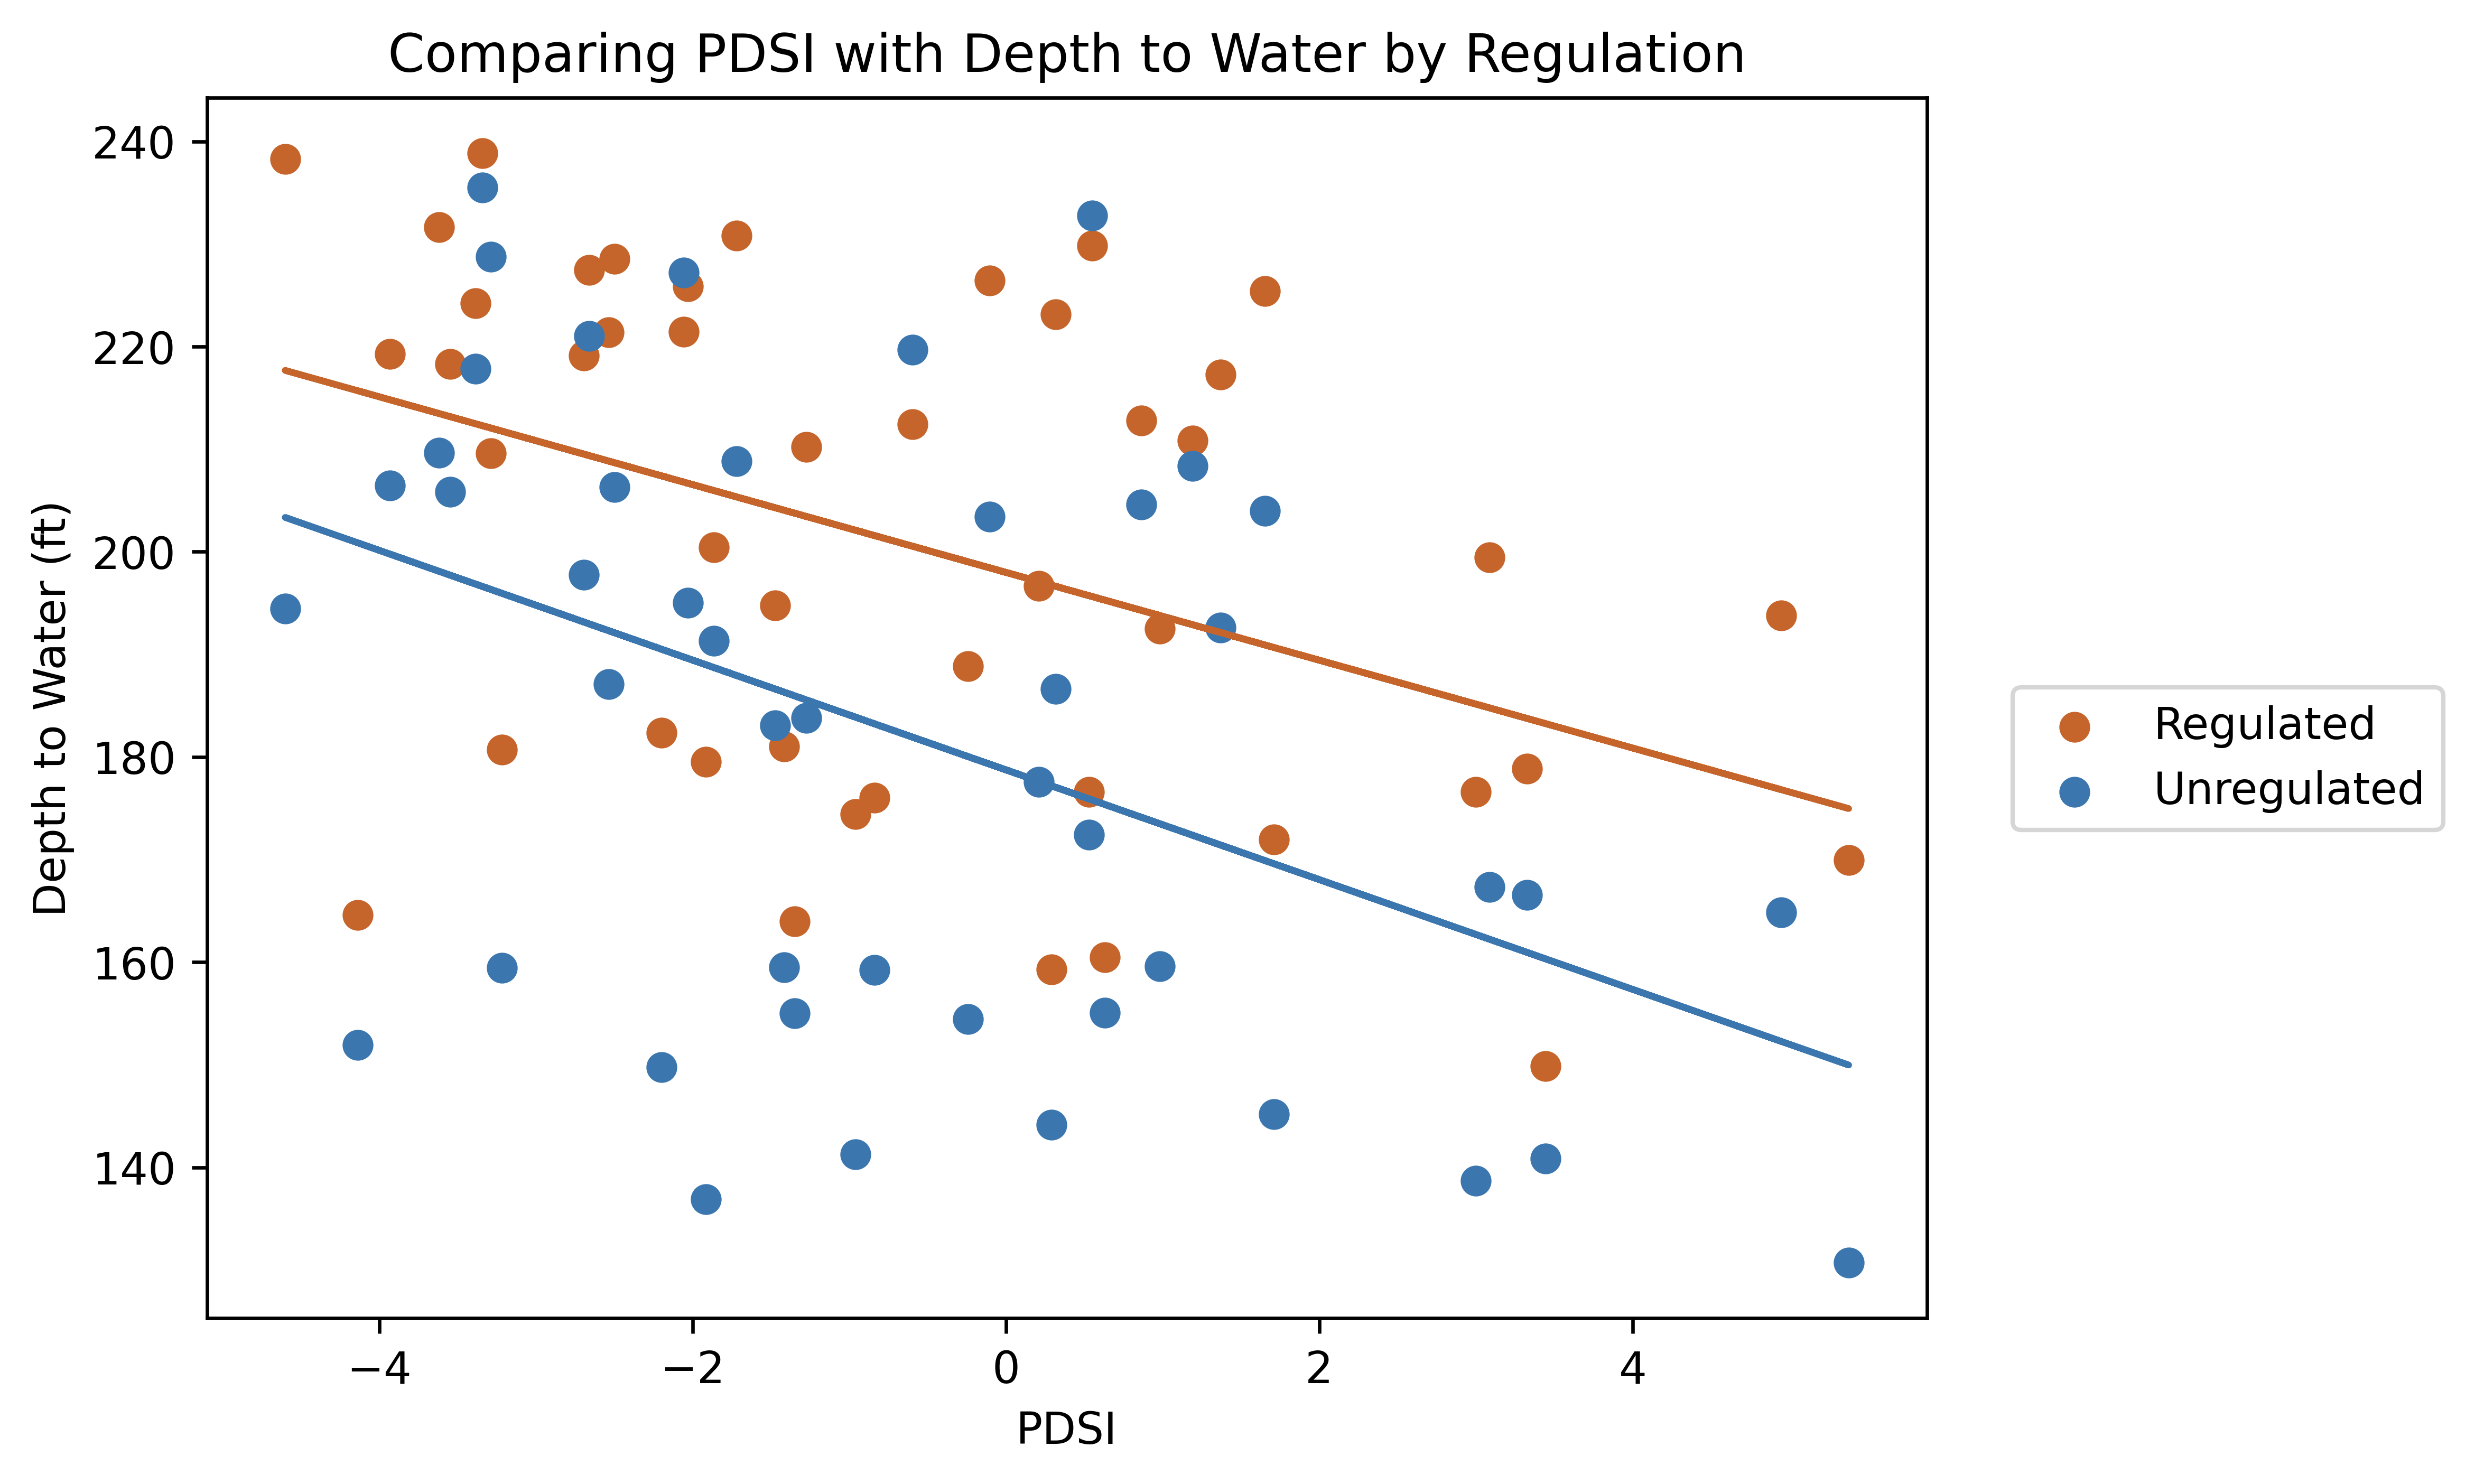

In [16]:
# %% Scatterplot of correlation values
ds = wlanalysis_period
# name = 'Comparing PDSI with Depth to Water by Access to SW'
name = 'Comparing '+indice+' with Depth to Water by Regulation'
# del ds['Res']
columns = ds.columns
column_list = ds.columns.tolist()
# betterlabels = ['Receives CAP (Regulated)','GW Dominated (Regulated)','Surface Water Dominated','GW Dominated','Mixed Source'] 
betterlabels = ['Regulated','Unregulated'] 
colors=[cap, GWdom]
# colors=[cap,noCAP, swdom, mixed, GWdom]

fig, ax = plt.subplots(figsize = (7,5))
x = drought_indices[indice]
for i,j,k in zip(column_list
                # ,reg_colors
                # , SW_colors
                , colors
                , betterlabels
                ):
        y = ds[i]
        ax.scatter(x,y
                , label=k
                , color=j
                )
        # Trendline: 1=Linear, 2=polynomial
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x, p(x),'-'
                , color=j
                # ,label=(k+' Trendline')
                )


ax.set_xlabel(indice)
ax.set_ylabel('Depth to Water (ft)')
ax.set_title(name,loc='center')
# ax.set_ylim(0,400)
fig.set_dpi(600)
plt.legend(loc = [1.05, 0.40])

plt.savefig(outputpath+name, bbox_inches='tight') 

For Calculating Anomlies

In [31]:
# Anomaly's
ds = wlanalysis_period.copy()
columns = ds.columns
column_list = ds.columns.tolist()
trend_df = wlanalysis_period.copy()
dtw_anomalys = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        df = ds[i]
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)
        # print(y)
        # slope, intercept = sp.linregress(x,y) 
        trend_df[i] = (wlanalysis_period.index*slope) + intercept
        dtw_anomalys[i] = wlanalysis_period[i] - trend_df[i]
        

dtw_anomalys.head()

R          U
index                     
1975   9.613013  21.969728
1976   1.727506   1.749720
1977   5.507541  -4.634793
1978   1.267475  -4.803269
1979  -6.642692 -14.790455

In [ ]:
trend_df

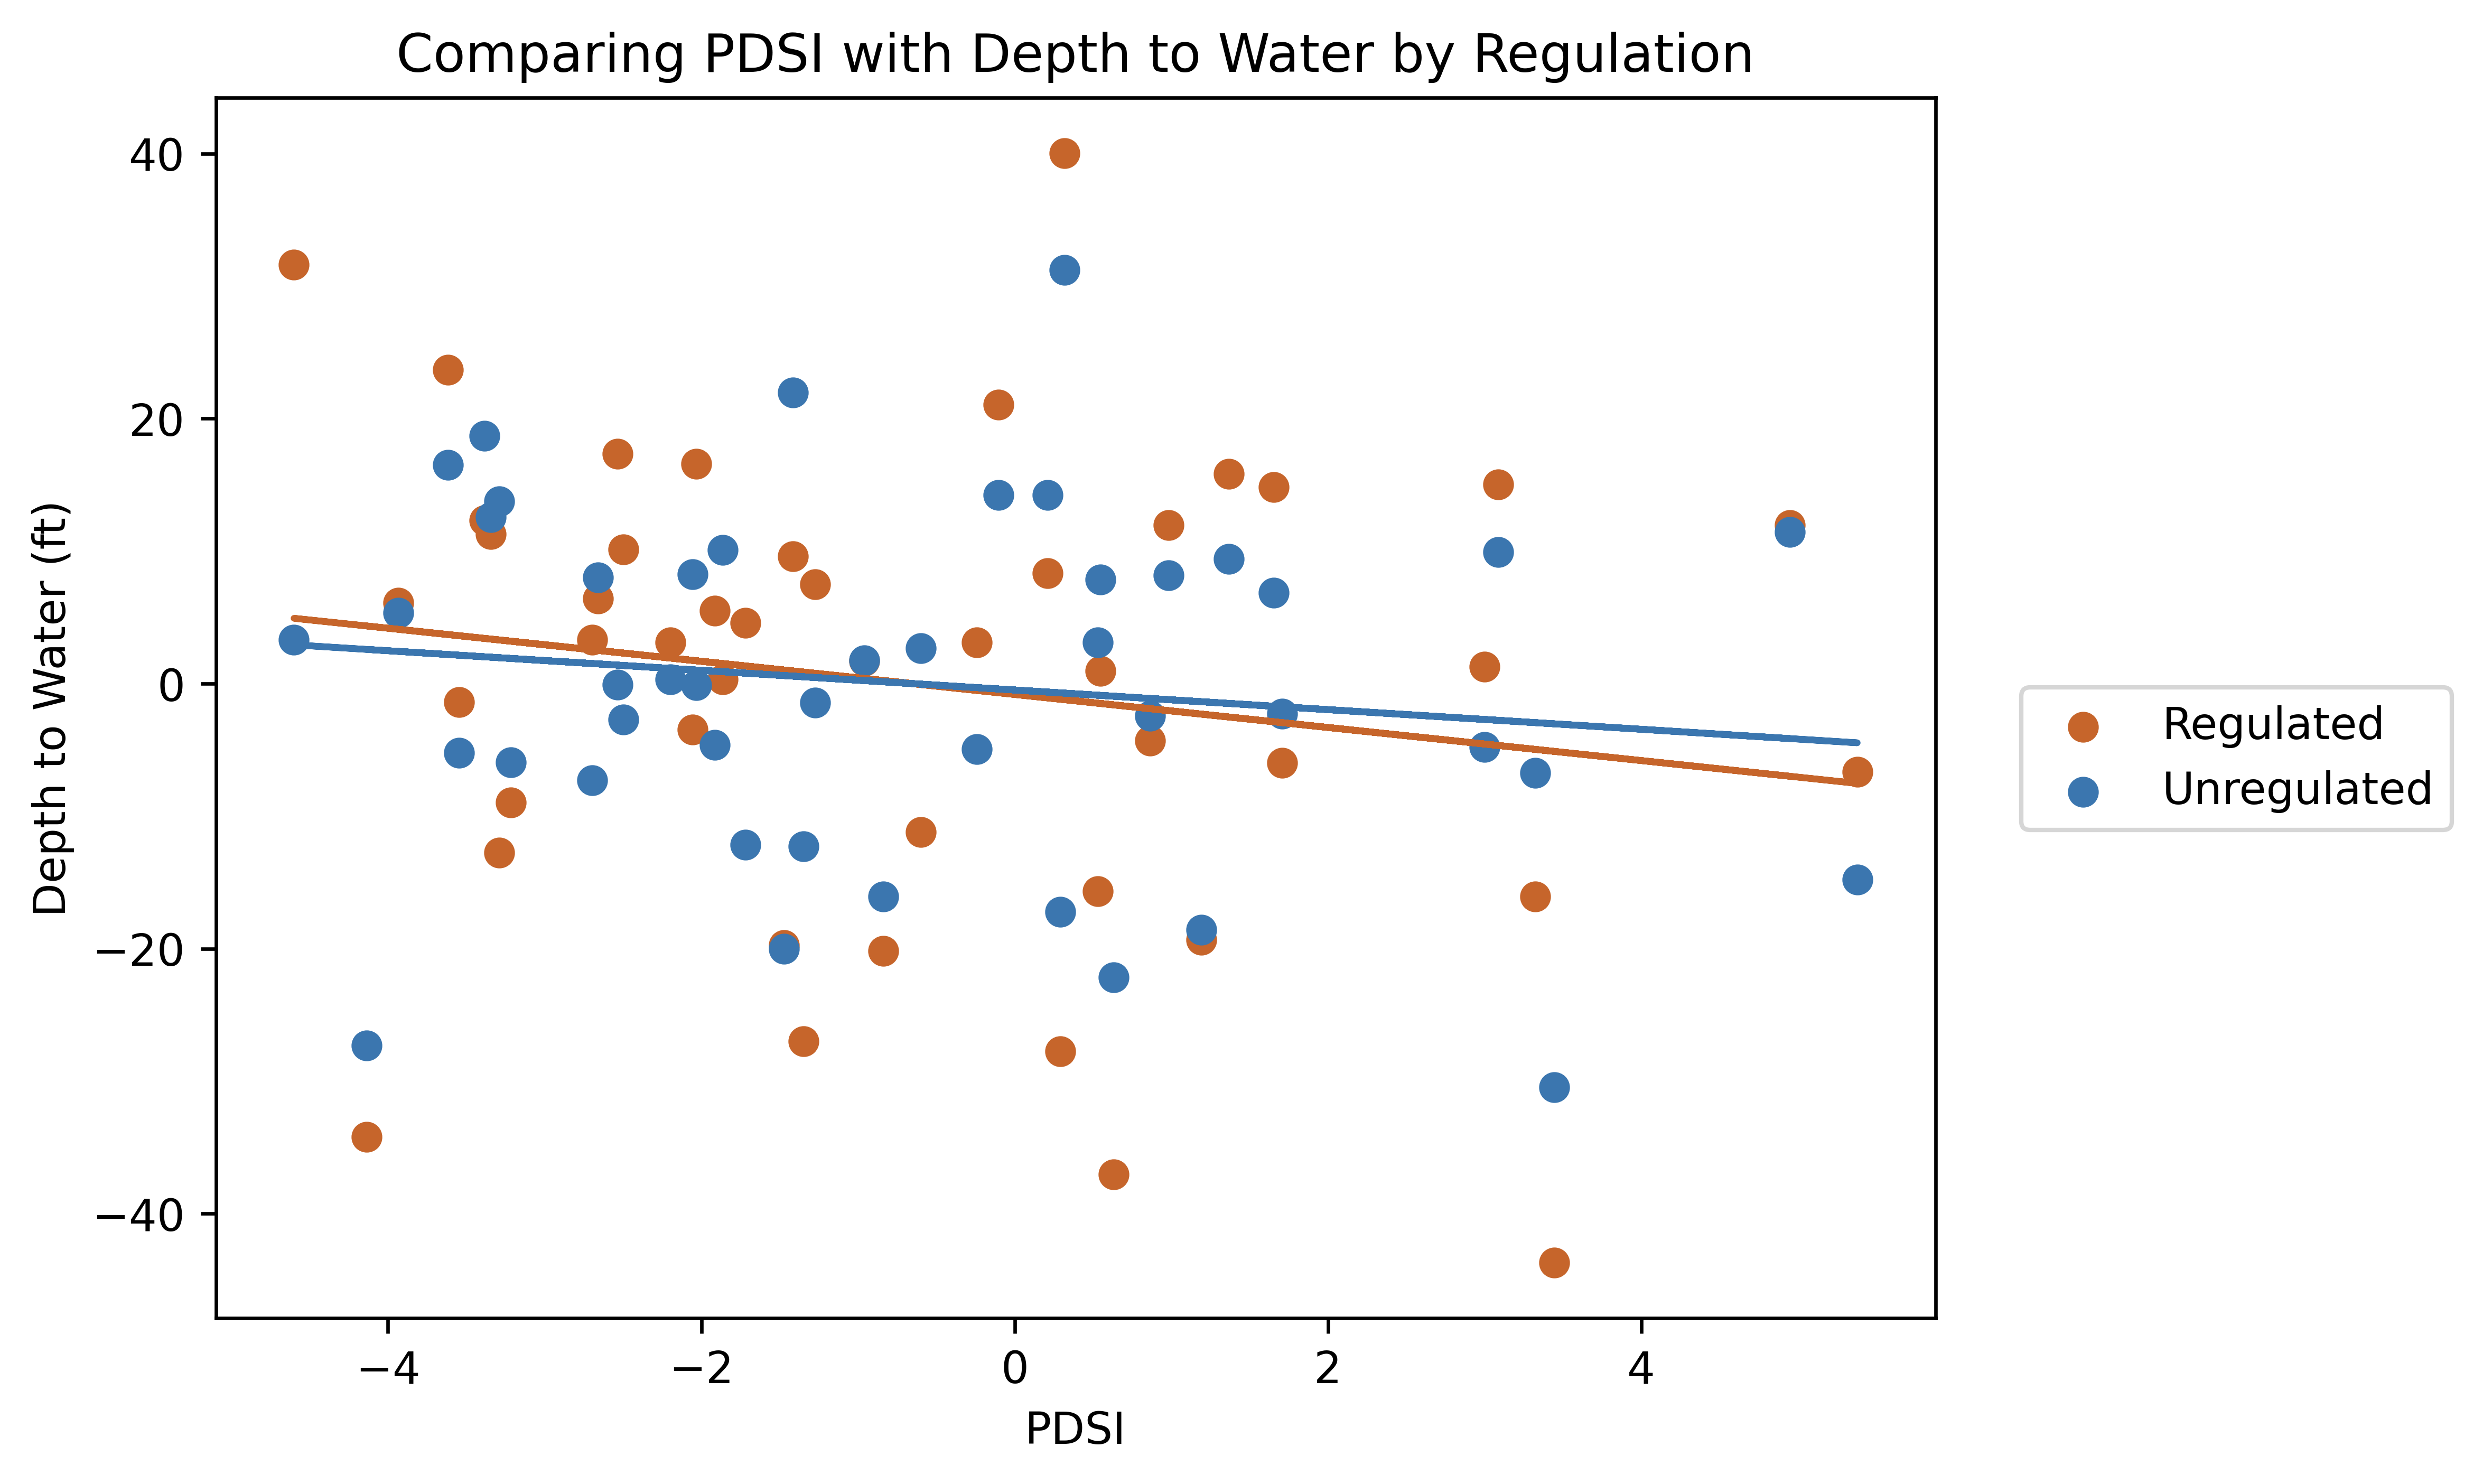

In [20]:
# %% Scatterplot of correlation values
ds = dtw_anomalys
# name = 'Comparing PDSI with Depth to Water by Access to SW'
name = 'Comparing '+indice+' with Depth to Water by Regulation'
# del ds['Res']
columns = ds.columns
column_list = ds.columns.tolist()
# betterlabels = ['Receives CAP (Regulated)','GW Dominated (Regulated)','Surface Water Dominated','GW Dominated','Mixed Source'] 
betterlabels = ['Regulated','Unregulated'] 
colors=[cap, GWdom]
# colors=[cap,noCAP, swdom, mixed, GWdom]

fig, ax = plt.subplots(figsize = (7,5))
x = drought_indices[indice]
for i,j,k in zip(column_list
                # ,reg_colors
                # , SW_colors
                , colors
                , betterlabels
                ):
        y = ds[i]
        ax.scatter(x,y
                , label=k
                , color=j
                )
        # Trendline: 1=Linear, 2=polynomial
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x, p(x),'-'
                , color=j
                # ,label=(k+' Trendline')
                )


ax.set_xlabel(indice)
ax.set_ylabel('Depth to Water (ft)')
ax.set_title(name,loc='center')
# ax.set_ylim(0,400)
fig.set_dpi(600)
plt.legend(loc = [1.05, 0.40])

plt.savefig(outputpath+name, bbox_inches='tight') 

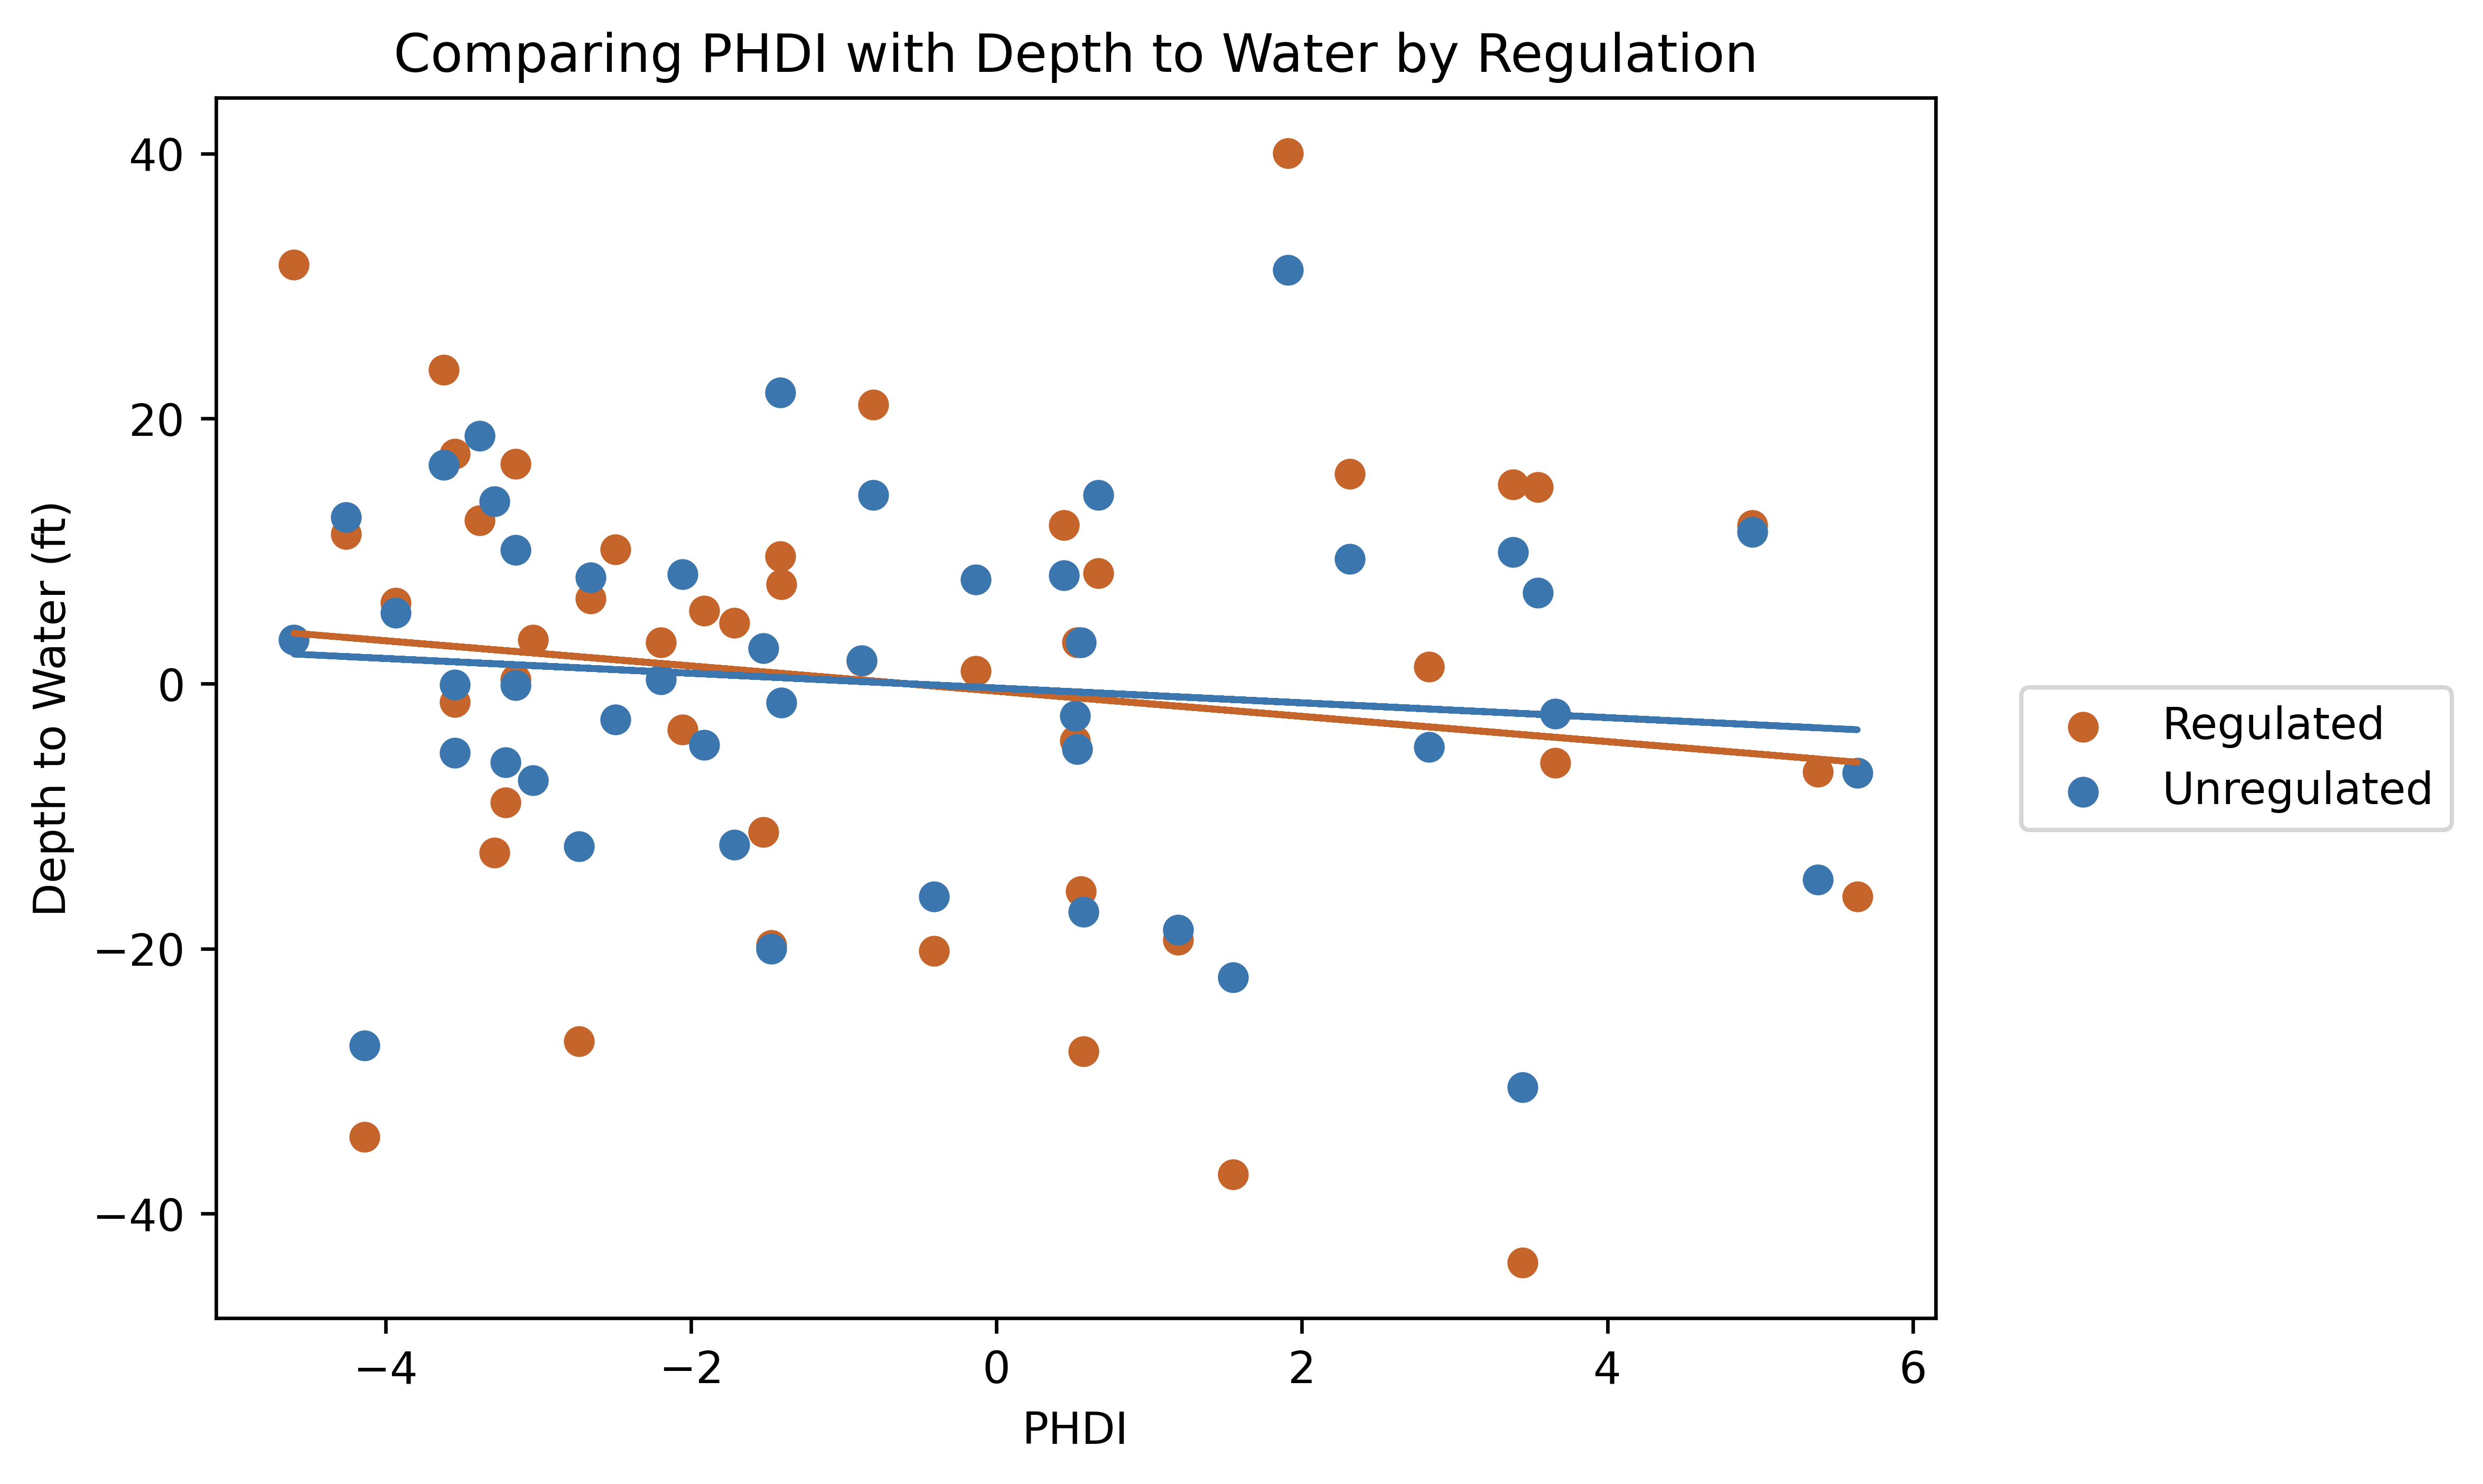

In [21]:
# Doing this for PHDI
indice = 'PHDI'
# %% Scatterplot of correlation values

ds = dtw_anomalys
# name = 'Comparing PDSI with Depth to Water by Access to SW'
name = 'Comparing '+indice+' with Depth to Water by Regulation'
# del ds['Res']
columns = ds.columns
column_list = ds.columns.tolist()
# betterlabels = ['Receives CAP (Regulated)','GW Dominated (Regulated)','Surface Water Dominated','GW Dominated','Mixed Source'] 
betterlabels = ['Regulated','Unregulated'] 
colors=[cap, GWdom]
# colors=[cap,noCAP, swdom, mixed, GWdom]

fig, ax = plt.subplots(figsize = (7,5))
x = drought_indices[indice]
for i,j,k in zip(column_list
                # ,reg_colors
                # , SW_colors
                , colors
                , betterlabels
                ):
        y = ds[i]
        ax.scatter(x,y
                , label=k
                , color=j
                )
        # Trendline: 1=Linear, 2=polynomial
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x, p(x),'-'
                , color=j
                # ,label=(k+' Trendline')
                )


ax.set_xlabel(indice)
ax.set_ylabel('Depth to Water (ft)')
ax.set_title(name,loc='center')
# ax.set_ylim(0,400)
fig.set_dpi(600)
plt.legend(loc = [1.05, 0.40])

plt.savefig(outputpath+name, bbox_inches='tight') 

In [22]:
# %% Average Anomalie for drought periods
ds = dtw_anomalys.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


dtw_mean_anomalies = ds.groupby(['Status']).mean()
dtw_mean_anomalies
# ds

R          U
Status                          
Drought 1  -17.979316  -9.114450
Drought 2  -34.211052 -27.311164
Drought 3   27.652019   9.912070
Drought 4    9.221969  12.027516
Drought 5   -2.576413   5.519885
Drought 6   11.266108  12.547603
Normal-Wet  -0.203290  -0.784182

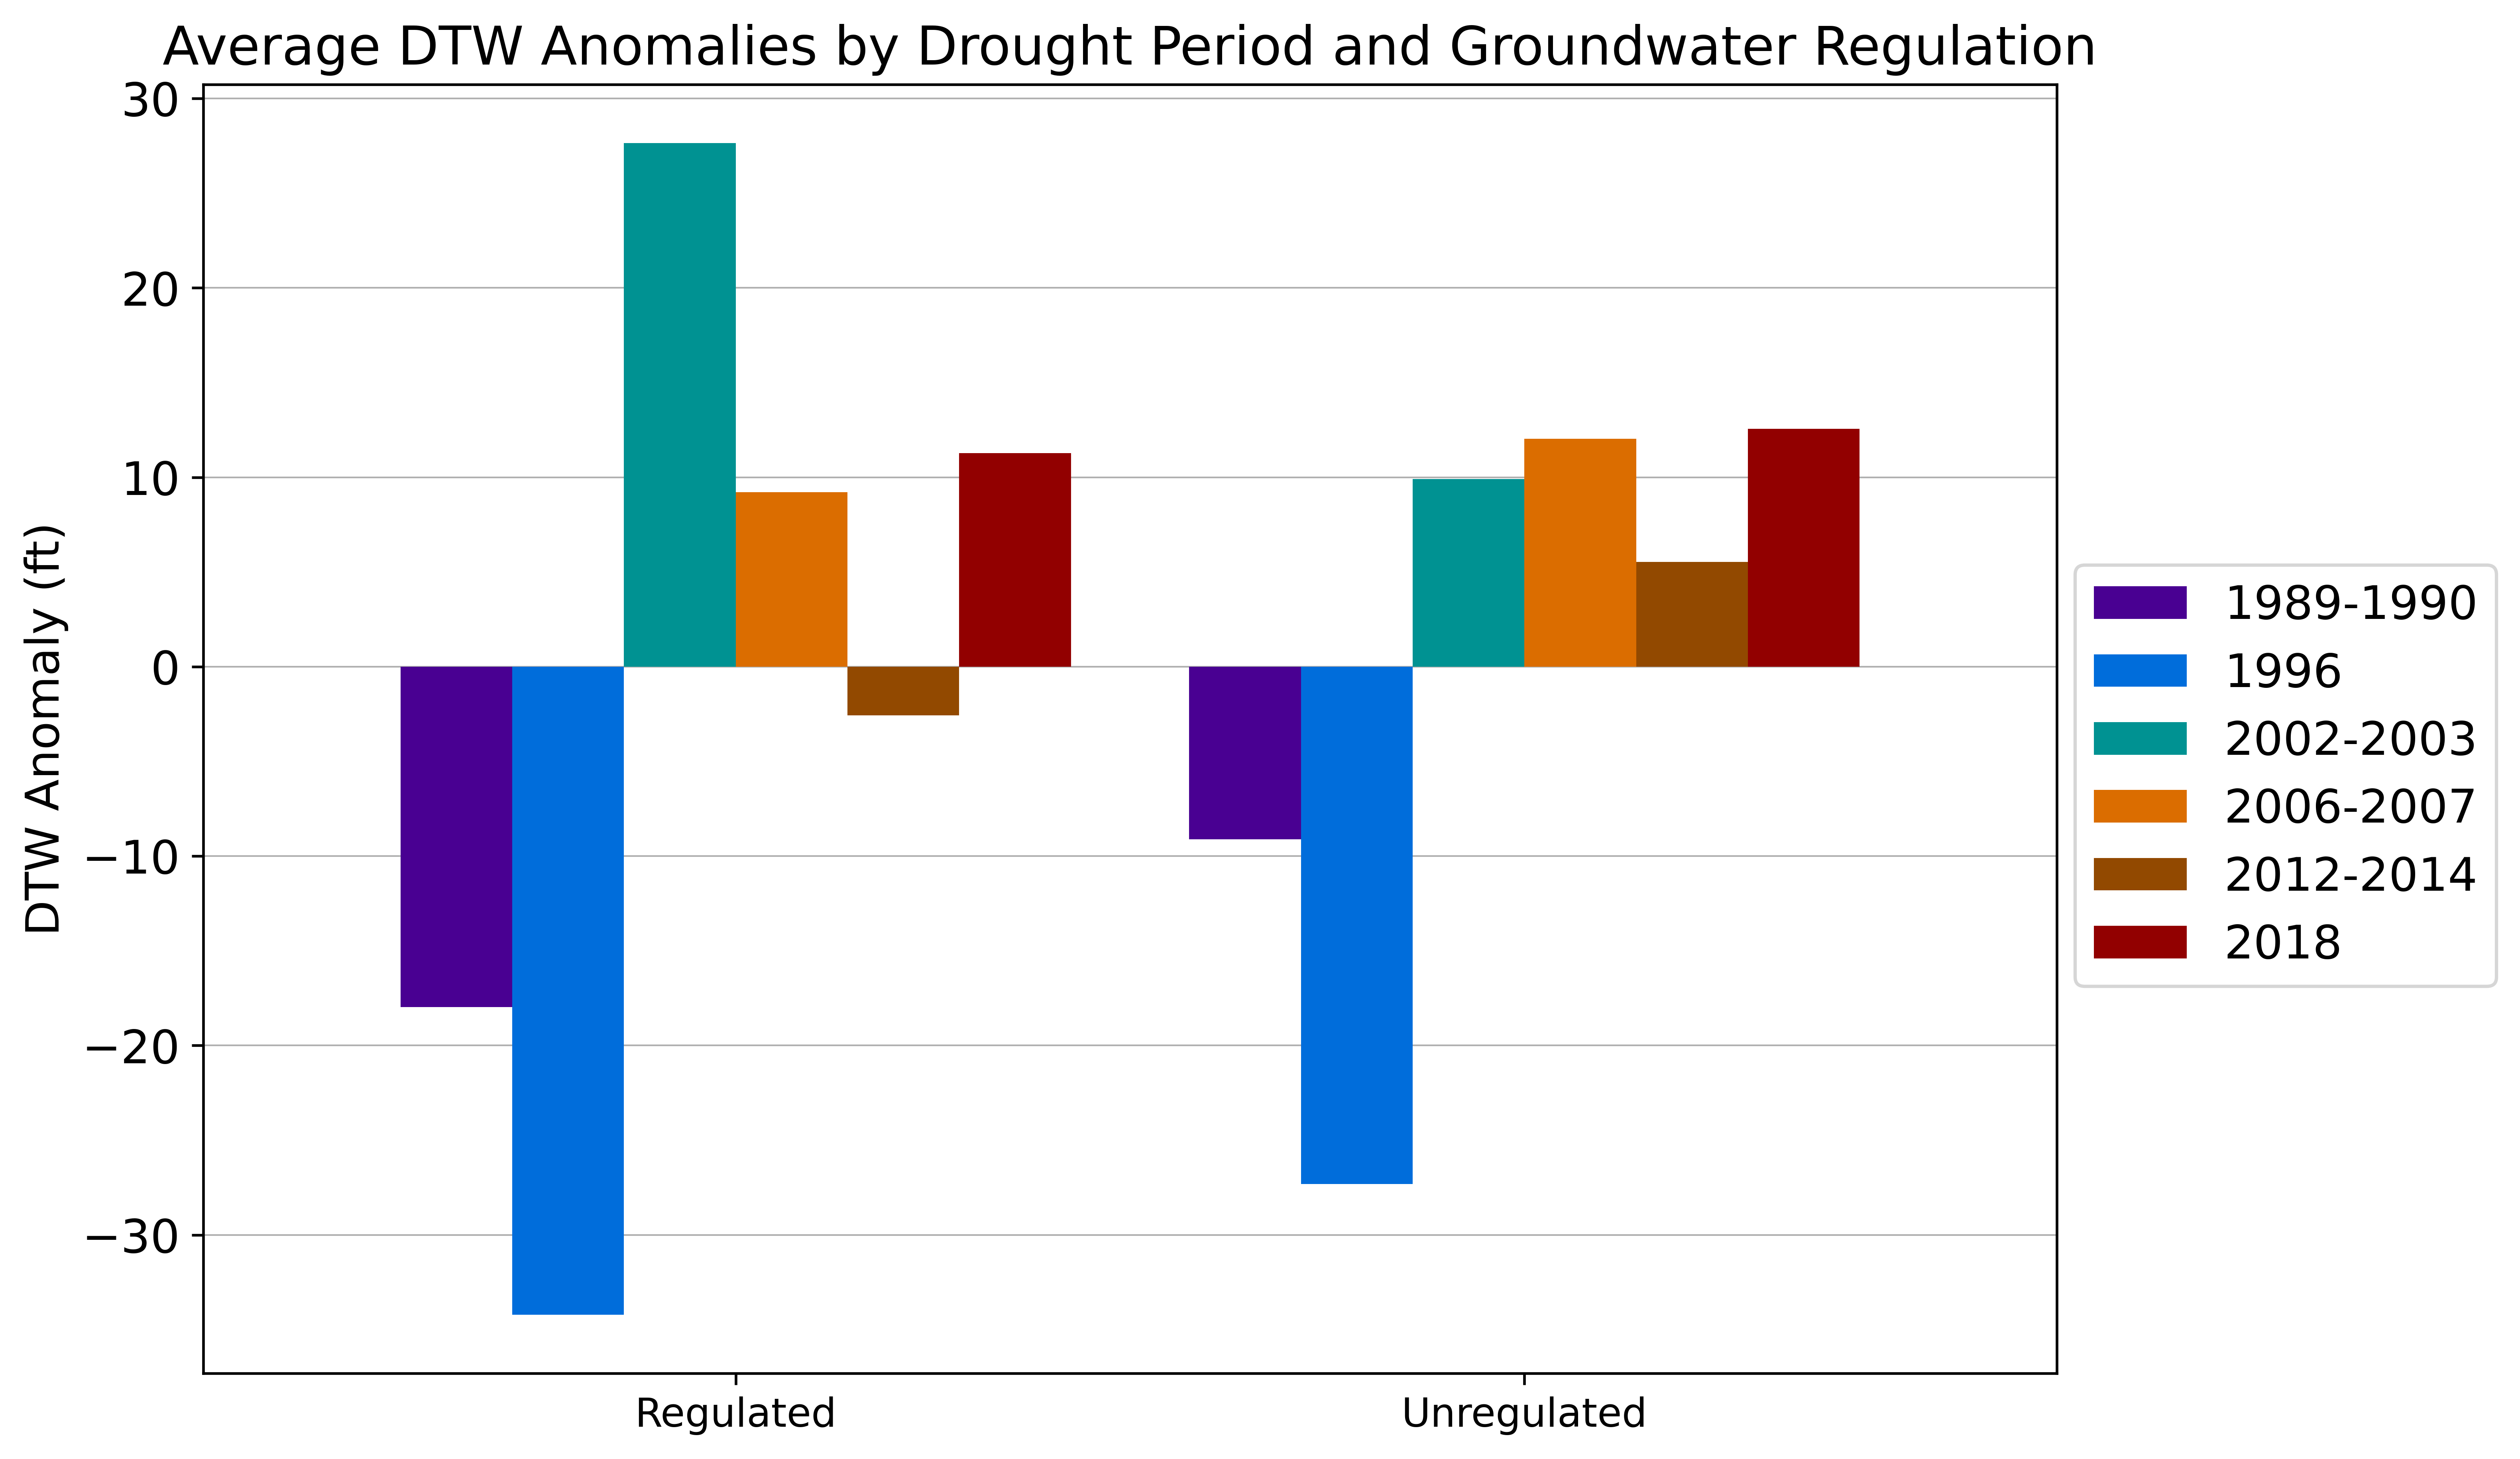

In [23]:
#%% Grouped Bar chart for drawdown (ft)
name = 'Average DTW Anomalies by Drought Period and Groundwater Regulation'
# name = 'Max Drawdown by Drought Period and Access to SW'

yearlabels = ["1989-1990",'1996','2002-2003','2006-2007','2012-2014','2018','Normal/Wet Years']
# betterlabels = ['CAP','Regulated \n Groundwater','Surface \n Water','Unregulated \n Groundwater','Mixed \n GW/SW'] 
betterlabels = ['Regulated','Unregulated']

dtw_mean_anomalies.index = yearlabels
dtw_mean_anomalies = dtw_mean_anomalies.transpose()

dtw_mean_anomalies.index = betterlabels
del dtw_mean_anomalies['Normal/Wet Years']
dtw_mean_anomalies


# group_colors = ['lightsalmon','tomato','orangered','r','brown','indianred','steelblue']

group_colors = [blind[5],blind[6],blind[2]
                ,blind[12],blind[11],blind[10]
                # ,blind[0] #black
                ]

horlabel = 'DTW Anomaly (ft)'
fsize = 14

plt.rcParams["figure.dpi"] = 600
dtw_mean_anomalies.plot(figsize = (10,7),
        kind='bar',
        stacked=False,
        # title=name,
        color = group_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
plt.title(name, fontsize = (fsize+2))
# plt.ylim([0,400])
plt.ylabel(horlabel, fontsize = fsize)
plt.xticks(rotation=0, fontsize = fsize-2)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)

plt.savefig(figurepath+name+'_groupedchart', bbox_inches = 'tight')
# plt.savefig(outputpath+name+'_anomalies_SWAccess_groupedchart', bbox_inches = 'tight')

For Drawdown

In [68]:
# %% Max drawdown
ds = wlanalysis_period.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


drought_max = ds.groupby(['Status']).max()
drought_max
# ds

R           U
Status                            
Drought 1   180.712773  159.418976
Drought 2   164.610175  151.940624
Drought 3   238.270432  209.671952
Drought 4   224.220432  217.820875
Drought 5   227.468807  228.765211
Drought 6   238.833255  235.502765
Normal-Wet  230.834913  232.780097

In [37]:
# Reworking drought

# %% Max drawdown
ds = wlanalysis_period.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period
trend_drought = trend_df.copy()
for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)
        trend_drought.loc[y, 'Status'] = 'Drought '+str(x)

ds = ds.reset_index()
drought_max = ds.groupby(['Status'],as_index=False).max()
drought_max
# trend_drought
# ds

Status  index           R           U
0   Drought 1   1990  180.712773  159.418976
1   Drought 2   1996  164.610175  151.940624
2   Drought 3   2003  238.270432  209.671952
3   Drought 4   2007  224.220432  217.820875
4   Drought 5   2014  227.468807  228.765211
5   Drought 6   2018  238.833255  235.502765
6  Normal-Wet   2020  230.834913  232.780097

Finding the corresponding values on the trendline

In [55]:
max_years = drought_max['index'].to_list()
max_years

for y in max_years:
    trend_drought.loc[y, 'max'] = y
trend_drought_max = trend_drought.groupby(['max']).max()
trend_drought_max = trend_drought_max[:-1]
trend_drought_max = trend_drought_max.set_index('Status')
trend_drought_max

R           U
Status                           
Drought 1  190.981431  167.332686
Drought 2  198.821227  179.251788
Drought 3  207.967657  193.157407
Drought 4  213.194188  201.103475
Drought 5  222.340617  215.009094
Drought 6  227.567148  222.955162

Reformatting the max drawdown values

In [57]:
drought_max = drought_max.set_index('Status')
del drought_max['index']
drought_max = drought_max[:-1]
drought_max

R           U
Status                           
Drought 1  180.712773  159.418976
Drought 2  164.610175  151.940624
Drought 3  238.270432  209.671952
Drought 4  224.220432  217.820875
Drought 5  227.468807  228.765211
Drought 6  238.833255  235.502765

Now actually calculating drawdown against the corresponding trend values

In [58]:
drawdown_trend = drought_max - trend_drought_max
drawdown_trend

R          U
Status                         
Drought 1 -10.268658  -7.913709
Drought 2 -34.211052 -27.311164
Drought 3  30.302775  16.514545
Drought 4  11.026244  16.717400
Drought 5   5.128190  13.756117
Drought 6  11.266108  12.547603

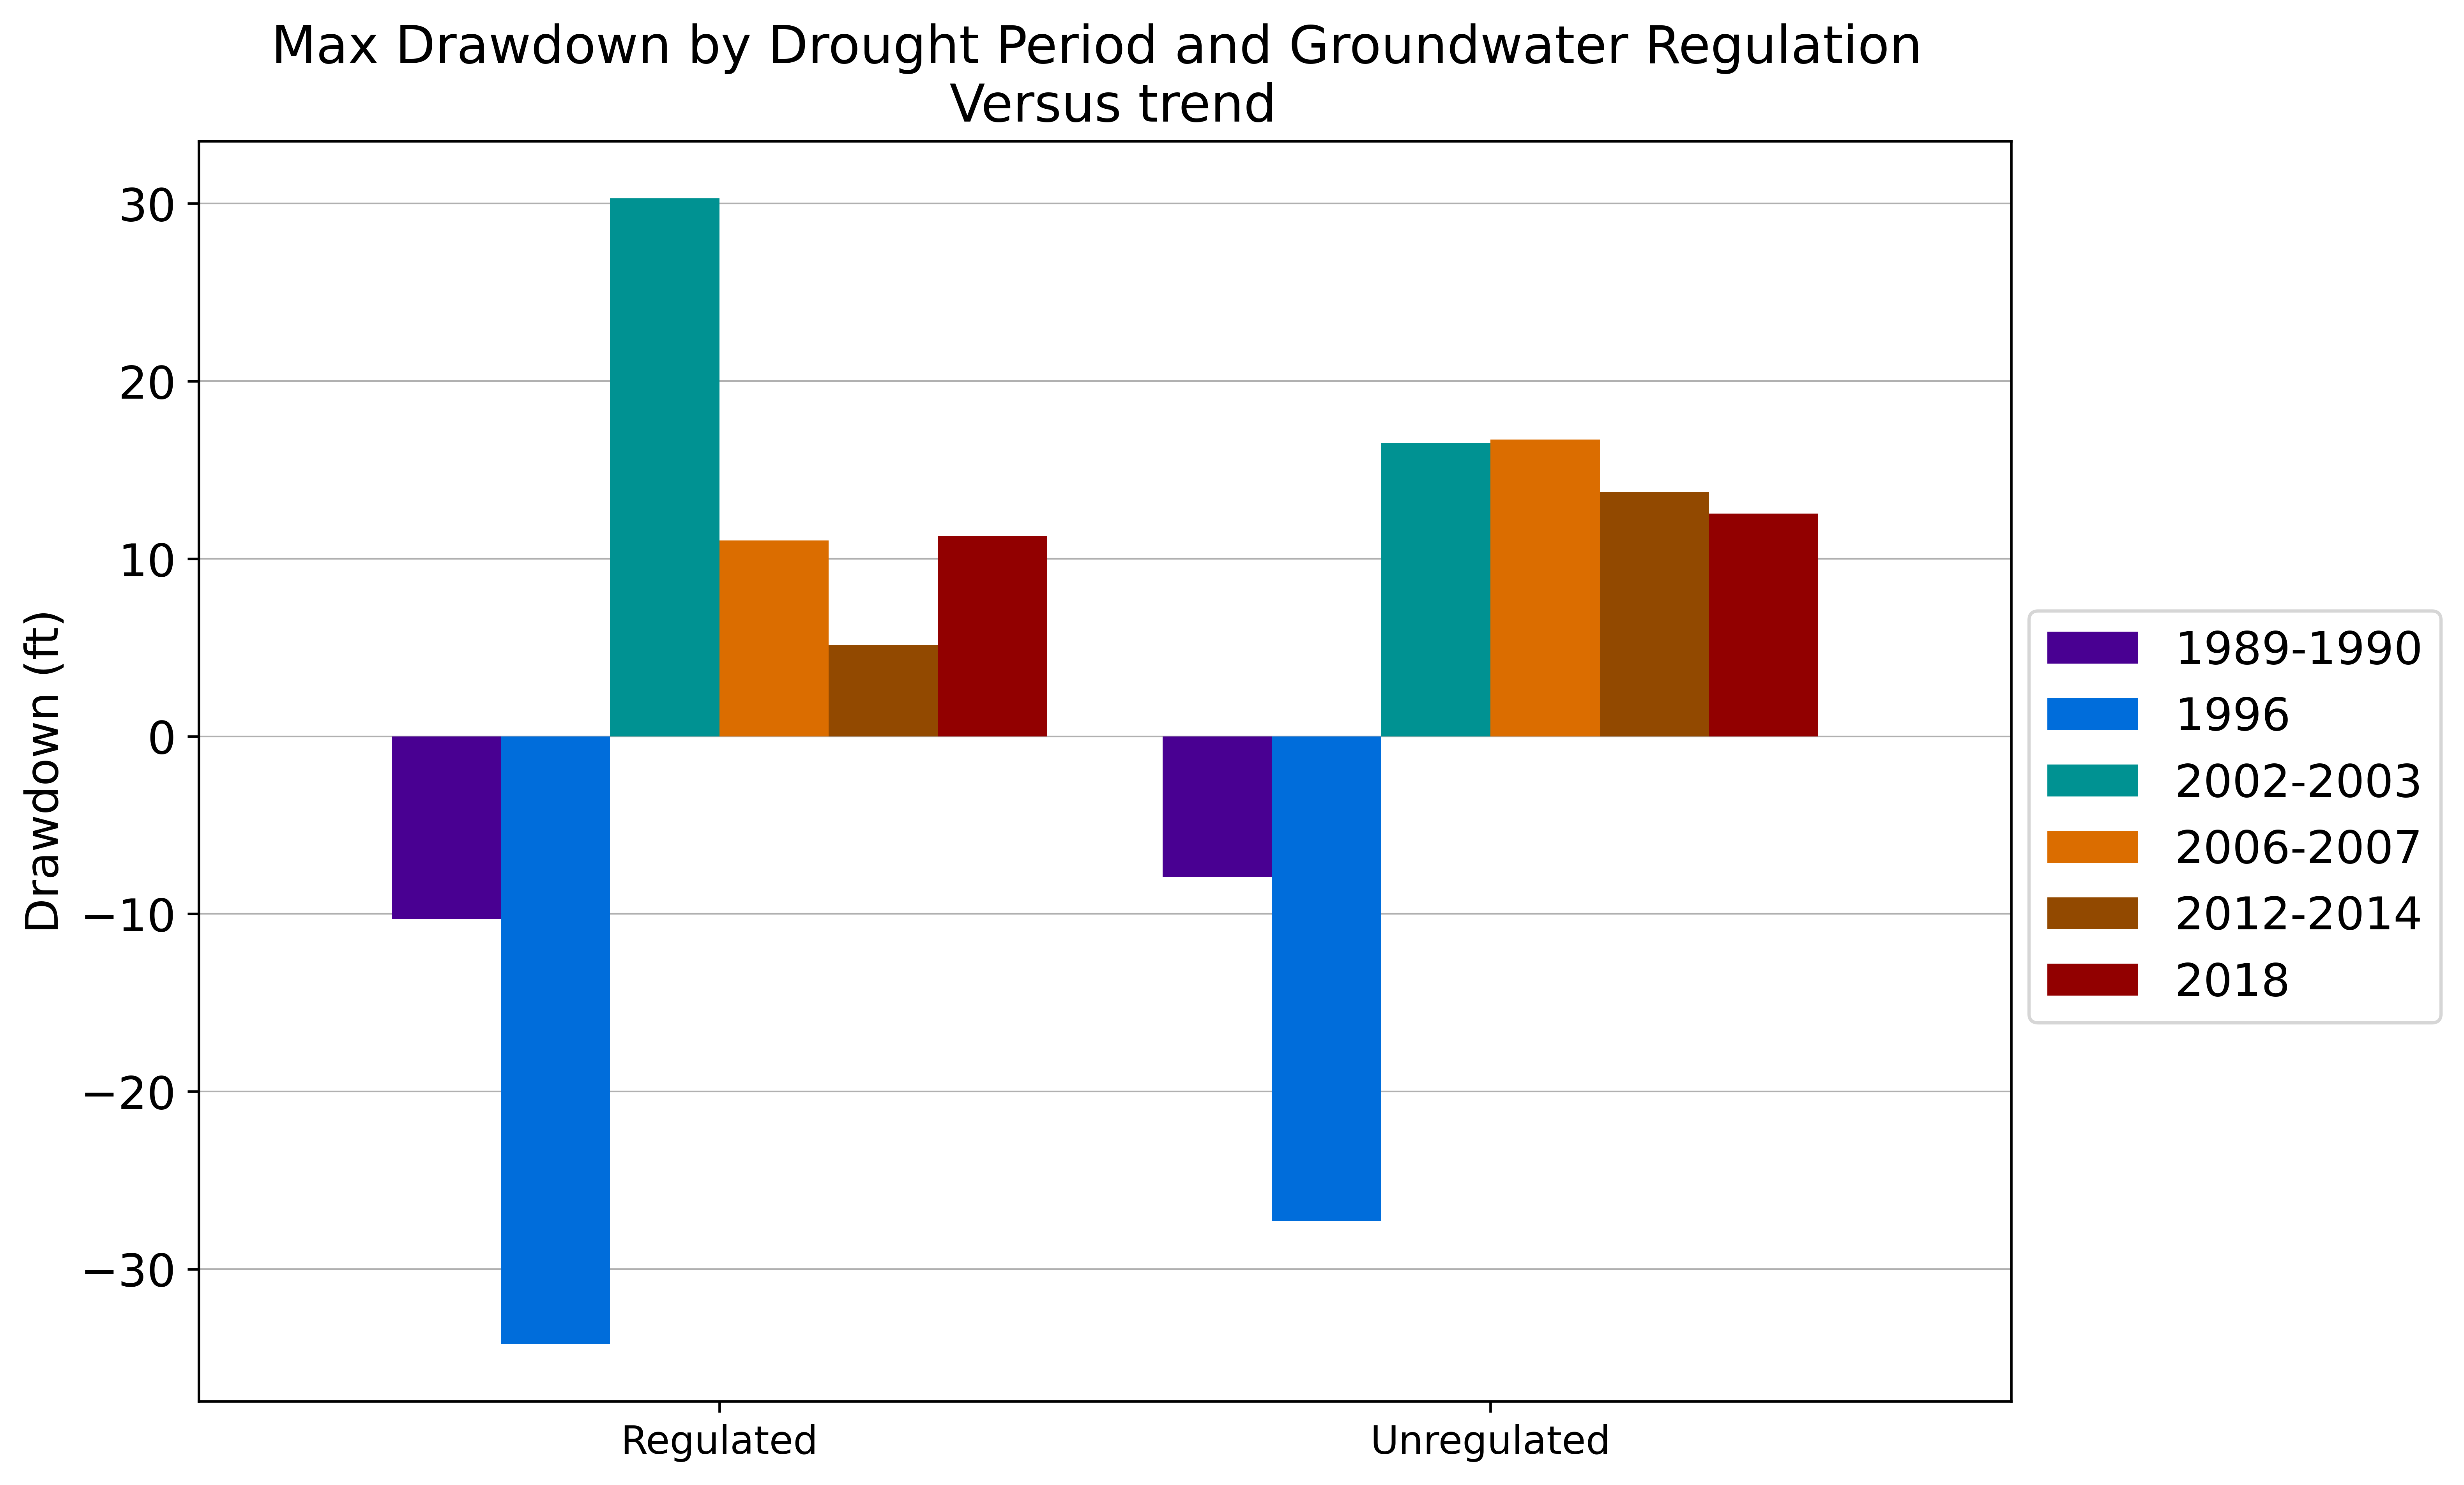

In [62]:
#%% Grouped Bar chart for drawdown (ft)
name = 'Max Drawdown by Drought Period and Groundwater Regulation \n Versus trend'
# name = 'Max Drawdown by Drought Period and Access to SW'

yearlabels = ["1989-1990",'1996','2002-2003','2006-2007','2012-2014','2018']
# betterlabels = ['CAP','Regulated \n Groundwater','Surface \n Water','Unregulated \n Groundwater','Mixed \n GW/SW'] 
betterlabels = ['Regulated','Unregulated']

drawdown_trend.index = yearlabels
drawdown_trend = drawdown_trend.transpose()
drawdown_trend
drawdown_trend.index = betterlabels
# del drawdown['Normal/Wet Years']

# group_colors = ['lightsalmon','tomato','orangered','r','brown','indianred','steelblue']

group_colors = [blind[5],blind[6],blind[2]
                ,blind[12],blind[11],blind[10]
                # ,blind[0] #black
                ]

horlabel = 'Drawdown (ft)'
fsize = 14

plt.rcParams["figure.dpi"] = 600
drawdown.plot(figsize = (10,7),
        kind='bar',
        stacked=False,
        # title=name,
        color = group_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
plt.title(name, fontsize = (fsize+2))
# plt.ylim([0,400])
plt.ylabel(horlabel, fontsize = fsize)
plt.xticks(rotation=0, fontsize = fsize-2)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)

plt.savefig(figurepath+name+'_groupedchart', bbox_inches = 'tight')
# plt.savefig(outputpath+name+'_anomalies_SWAccess_groupedchart', bbox_inches = 'tight')

This is for calculating against the average for Normal-Wet periods

In [19]:
# Predrought values
ds = wlanalysis_period.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'

for x,y in PREDROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)

ds
predrought = ds.groupby(['Status']).mean()
predrought

R           U
Status                            
Drought 1   184.064133  152.233825
Drought 2   170.331708  159.767962
Drought 3   212.335055  188.709985
Drought 4   225.849473  195.042627
Drought 5   214.046204  201.943075
Drought 6   216.945755  223.454407
Normal-Wet  210.733020  197.531387

Now for calculating against the slope

In [20]:
# Predrought values
import pandas as pd
ds = wlanalysis_period.copy()
columns = ds.columns
column_list = ds.columns.tolist()

labels = ['R','U']
stats = pd.DataFrame()
for i in column_list:
        df = ds[i]
        # df = f[i].pct_change()
        #print(df)
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
        stats = stats._append({'slope': slope,
                               'int':intercept
                        },
                        ignore_index=True)


stats.index = labels
stats1 = stats.transpose()
stats1

R            U
slope     1.306633     1.986517
int   -2409.217735 -3785.836173

y = m x + b

y is the value
m is stats1[i,'slope']
b is stats1[i,'slope']

In [21]:
stats1.loc['slope','R']

1.306632746899067

In [22]:
# Predrought values
ds = wlanalysis_period.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'

for x,y in PREDROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)

ds
# predrought = ds.groupby(['Status']).mean()
# predrought

R           U      Status
index                                    
1975   180.994953  159.504658   Drought 1
1976   174.416079  141.271168   Drought 1
1977   179.502746  136.873172   Drought 1
1978   176.569313  138.691213   Drought 1
1979   169.965778  130.690543   Drought 1
1980   171.947298  145.178593   Drought 1
1981   182.343093  149.781837   Drought 1
1982   192.491747  159.604408   Drought 1
1983   193.812877  164.875290   Drought 1
1984   223.159779  186.625763   Drought 1
1985   199.471580  167.341710   Drought 1
1986   188.850279  154.437783   Drought 1
1987   159.308209  144.163586   Drought 1
1988   196.681660  177.591402  Normal-Wet
1989   180.712773  159.418976  Normal-Wet
1990   163.984824  155.030978  Normal-Wet
1991   176.600191  172.428798   Drought 2
1992   149.878944  140.858138   Drought 2
1993   178.836600  166.559869   Drought 2
1994   176.011096  159.225044   Drought 2
1995   160.480246  155.075218  Normal-Wet
1996   164.610175  151.940624  Normal-Wet
1997   200.436868  191.324384   Drought 3
1998   217.267431  192.627766   Drought 3
1999   210.229417  183.778651   Drought 3
2000   221.406505  187.109141   Drought 3
2001   226.414098  203.431008  Normal-Wet
2002   238.270432  194.480484  Normal-Wet
2003   231.662286  209.671952  Normal-Wet
2004   225.849473  195.042627   Drought 4
2005   225.402616  203.971972  Normal-Wet
2006   224.220432  217.820875   Drought 5
2007   219.305250  206.454590   Drought 5
2008   194.780640  183.056197   Drought 5
2009   219.115873  197.759114   Drought 5
2010   212.808823  204.624599   Drought 5
2011   228.530210  206.329765  Normal-Wet
2012   218.326169  205.816077  Normal-Wet
2013   227.468807  221.046098  Normal-Wet
2014   209.577737  228.765211  Normal-Wet
2015   212.427271  219.675857   Drought 6
2016   221.464240  227.232957   Drought 6
2017   230.834913  208.818241  Normal-Wet
2018   238.833255  235.502765  Normal-Wet
2019   229.832993  232.780097  Normal-Wet
2020   210.838140  208.362709  Normal-Wet

In [74]:
# ds = predrought
predrought_slope = ds.copy()
for i in column_list:
    print(i)
    m = stats1.loc['slope',i]
    b = stats1.loc['int',i]
    x = predrought_slope[i].index*m + b
    # print(x)
    predrought_slope[i] = x
#     predrought_slope = predrought_slope._append(x)

predrought_slope
    

R
U


R           U      Status
index                                    
1975   171.381940  137.534930   Drought 1
1976   172.688572  139.521447   Drought 1
1977   173.995205  141.507964   Drought 1
1978   175.301838  143.494481   Drought 1
1979   176.608471  145.480998   Drought 1
1980   177.915103  147.467515   Drought 1
1981   179.221736  149.454032   Drought 1
1982   180.528369  151.440549   Drought 1
1983   181.835002  153.427066   Drought 1
1984   183.141634  155.413583   Drought 1
1985   184.448267  157.400101   Drought 1
1986   185.754900  159.386618   Drought 1
1987   187.061533  161.373135   Drought 1
1988   188.368165  163.359652  Normal-Wet
1989   189.674798  165.346169  Normal-Wet
1990   190.981431  167.332686  Normal-Wet
1991   192.288064  169.319203   Drought 2
1992   193.594696  171.305720   Drought 2
1993   194.901329  173.292237   Drought 2
1994   196.207962  175.278754   Drought 2
1995   197.514595  177.265271  Normal-Wet
1996   198.821227  179.251788  Normal-Wet
1997   200.127860  181.238305   Drought 3
1998   201.434493  183.224822   Drought 3
1999   202.741126  185.211339   Drought 3
2000   204.047758  187.197856   Drought 3
2001   205.354391  189.184373  Normal-Wet
2002   206.661024  191.170890  Normal-Wet
2003   207.967657  193.157407  Normal-Wet
2004   209.274289  195.143924   Drought 4
2005   210.580922  197.130441  Normal-Wet
2006   211.887555  199.116958   Drought 5
2007   213.194188  201.103475   Drought 5
2008   214.500820  203.089992   Drought 5
2009   215.807453  205.076509   Drought 5
2010   217.114086  207.063026   Drought 5
2011   218.420719  209.049543  Normal-Wet
2012   219.727351  211.036060  Normal-Wet
2013   221.033984  213.022577  Normal-Wet
2014   222.340617  215.009094  Normal-Wet
2015   223.647250  216.995611   Drought 6
2016   224.953882  218.982128   Drought 6
2017   226.260515  220.968645  Normal-Wet
2018   227.567148  222.955162  Normal-Wet
2019   228.873781  224.941679  Normal-Wet
2020   230.180413  226.928196  Normal-Wet

In [75]:
predrought = predrought_slope.groupby(['Status']).mean()
predrought

R           U
Status                            
Drought 1   179.221736  149.454032
Drought 2   194.248013  172.298978
Drought 3   202.087809  184.218080
Drought 4   209.274289  195.143924
Drought 5   214.500820  203.089992
Drought 6   224.300566  217.988869
Normal-Wet  211.195808  198.065272

In [56]:
# %% Drawdown
drawdown = drought_max - predrought
# del drawdown['Status']
drawdown

R  Status   U  index
0         NaN     NaN NaN    NaN
1         NaN     NaN NaN    NaN
2         NaN     NaN NaN    NaN
3         NaN     NaN NaN    NaN
4         NaN     NaN NaN    NaN
5         NaN     NaN NaN    NaN
6         NaN     NaN NaN    NaN
Drought 1 NaN     NaN NaN    NaN
Drought 2 NaN     NaN NaN    NaN
Drought 3 NaN     NaN NaN    NaN
Drought 4 NaN     NaN NaN    NaN
Drought 5 NaN     NaN NaN    NaN
Drought 6 NaN     NaN NaN    NaN

In [61]:
#%% Grouped Bar chart for drawdown (ft)
name = 'Max Drawdown by Drought Period and Groundwater Regulation'
# name = 'Max Drawdown by Drought Period and Access to SW'

yearlabels = ["1989-1990",'1996','2002-2003','2006-2007','2012-2014','2018','Normal/Wet Years']
# betterlabels = ['CAP','Regulated \n Groundwater','Surface \n Water','Unregulated \n Groundwater','Mixed \n GW/SW'] 
betterlabels = ['Regulated','Unregulated']

drawdown.index = yearlabels
drawdown = drawdown.transpose()
drawdown
drawdown.index = betterlabels
del drawdown['Normal/Wet Years']
drawdown


# group_colors = ['lightsalmon','tomato','orangered','r','brown','indianred','steelblue']

group_colors = [blind[5],blind[6],blind[2]
                ,blind[12],blind[11],blind[10]
                # ,blind[0] #black
                ]

horlabel = 'Drawdown (ft)'
fsize = 14

plt.rcParams["figure.dpi"] = 600
drawdown.plot(figsize = (10,7),
        kind='bar',
        stacked=False,
        # title=name,
        color = group_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
plt.title(name, fontsize = (fsize+2))
# plt.ylim([0,400])
plt.ylabel(horlabel, fontsize = fsize)
plt.xticks(rotation=0, fontsize = fsize-2)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)

plt.savefig(figurepath+name+'_groupedchart', bbox_inches = 'tight')
# plt.savefig(outputpath+name+'_anomalies_SWAccess_groupedchart', bbox_inches = 'tight')

KeyError: 'Normal/Wet Years'

### For Access to Surface Water

In [47]:
cat_wl2 = cat_wl2_SW.copy()

wlanalysis_period = cat_wl2[cat_wl2.index>=1975]

For comparing to drought indices

In [48]:
# Some functions since it's not pulling from cf
def kendall_pval(x,y):
        return kendalltau(x,y)[1]
    
def pearsonr_pval(x,y):
        return pearsonr(x,y)[1]
    
def spearmanr_pval(x,y):
        return spearmanr(x,y)[1]

In [49]:

# %% If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0

ds = wlanalysis_period
columns = ds.columns
column_list = ds.columns.tolist()

print('Kendall Correlation coefficient')
for i in column_list:
        # print(' '+i+':')
        print(' '+str(i)+':')
# To normalize the data 
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices.PDSI.shift(lag)
        print('  tau = ',round(df1.corr(df2, method='kendall'),3))
        print('  pval = ',round(df1.corr(df2, method=kendall_pval),4))

# %%
print('Spearman Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices.PDSI.shift(lag)
        print('  rho = ',round(df1.corr(df2, method='spearman'),3))
        print('  pval = ',round(df1.corr(df2, method=spearmanr_pval),4))

# %%
print('Pearson Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices.PDSI.shift(lag)
        r = df1.corr(df2, method='pearson')
        print('  rsq = ',round(r*r,3))
        print('  pval = ',round(df1.corr(df2, method=pearsonr_pval),4))

Kendall Correlation coefficient
 CAP:
  tau =  -0.235
  pval =  0.0214
 No_CAP:
  tau =  -0.331
  pval =  0.0012
 SW:
  tau =  -0.146
  pval =  0.1528
 GW:
  tau =  -0.308
  pval =  0.0025
 Mix:
  tau =  -0.235
  pval =  0.0214
Spearman Correlation coefficient
 CAP:
  rho =  -0.335
  pval =  0.0227
 No_CAP:
  rho =  -0.459
  pval =  0.0013
 SW:
  rho =  -0.208
  pval =  0.1664
 GW:
  rho =  -0.433
  pval =  0.0027
 Mix:
  rho =  -0.348
  pval =  0.0177
Pearson Correlation coefficient
 CAP:
  rsq =  0.107
  pval =  0.0262
 No_CAP:
  rsq =  0.225
  pval =  0.0009
 SW:
  rsq =  0.063
  pval =  0.0928
 GW:
  rsq =  0.208
  pval =  0.0014
 Mix:
  rsq =  0.128
  pval =  0.0147


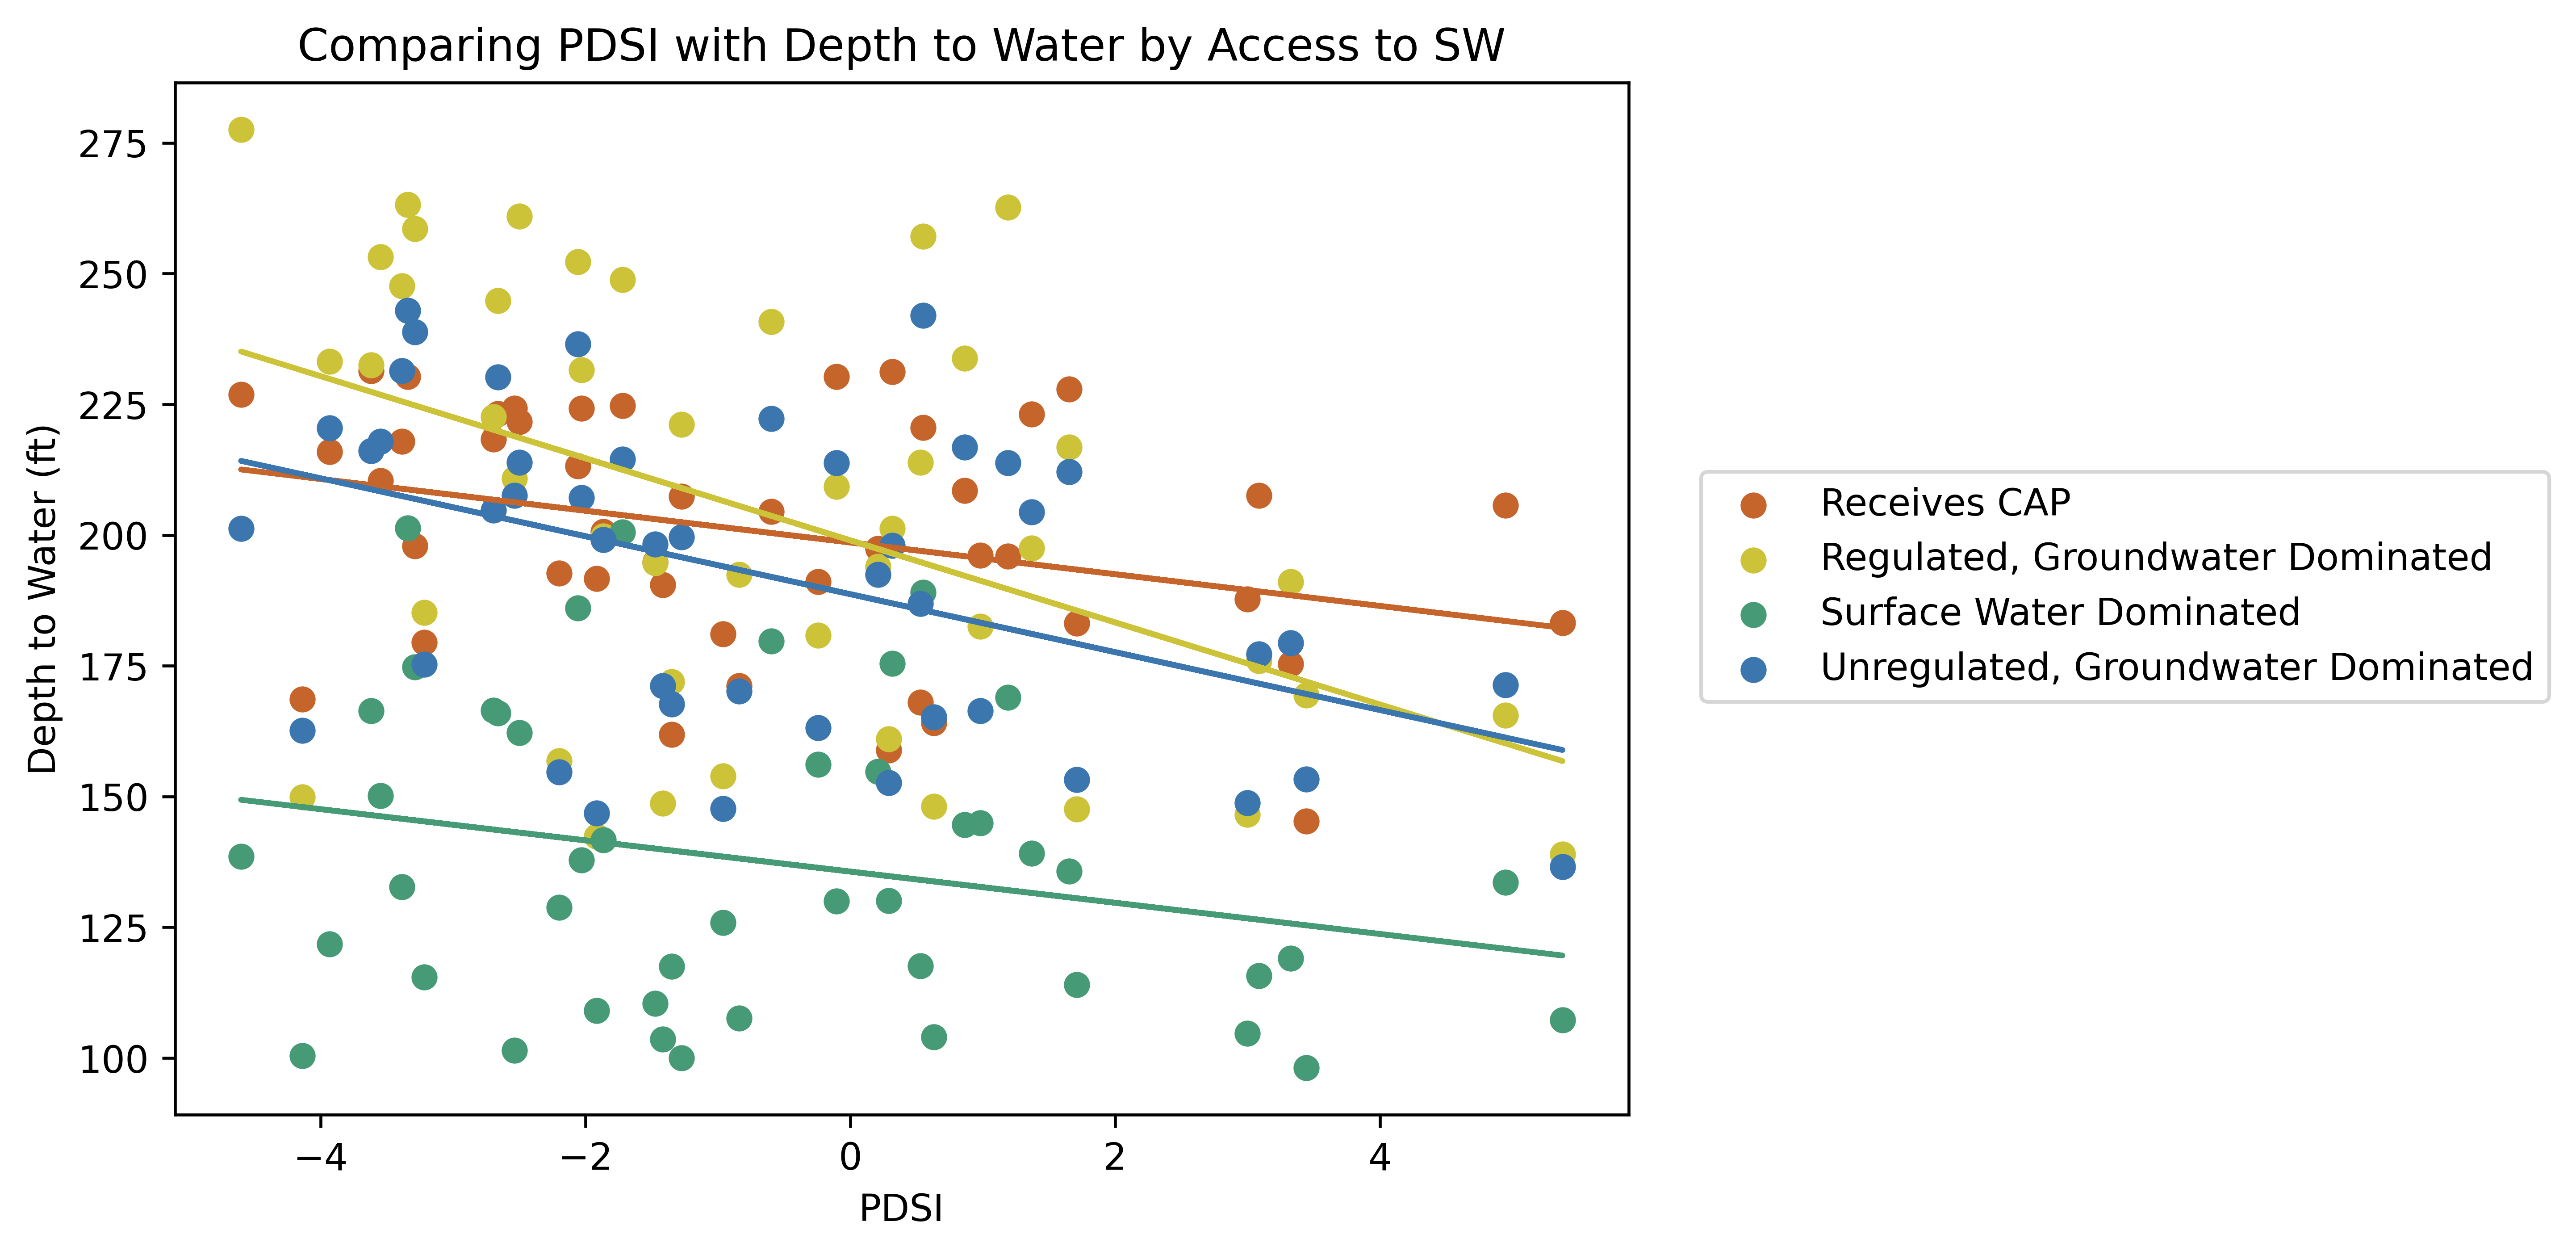

In [50]:
# %% Scatterplot of correlation values
ds = wlanalysis_period
name = 'Comparing PDSI with Depth to Water by Access to SW'
# name = 'Comparing PDSI with Depth to Water by Regulation'
# del ds['Res']
columns = ds.columns
column_list = ds.columns.tolist()
# betterlabels = ['Receives CAP (Regulated)','GW Dominated (Regulated)','Surface Water Dominated','GW Dominated','Mixed Source'] 
betterlabels = ['Receives CAP'
                ,'Regulated, Groundwater Dominated'
                ,'Surface Water Dominated'
                ,'Unregulated, Groundwater Dominated'
                # ,'Mixed \n GW/SW'
                ]
colors=[cap
        ,noCAP
        , swdom
        , GWdom
        # , mixed
        ]

fig, ax = plt.subplots(figsize = (7,5))
x = drought_indices['PDSI']
for i,j,k in zip(column_list
                # ,reg_colors
                # , SW_colors
                , colors
                , betterlabels
                ):
        y = ds[i]
        ax.scatter(x,y
                , label=k
                , color=j
                )
        # Trendline: 1=Linear, 2=polynomial
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x, p(x),'-'
                , color=j
                # ,label=(k+' Trendline')
                )


ax.set_xlabel('PDSI')
ax.set_ylabel('Depth to Water (ft)')
ax.set_title(name,loc='center')
# ax.set_ylim(0,400)
fig.set_dpi(600)
plt.legend(loc = [1.05, 0.40])

plt.savefig(outputpath+name, bbox_inches='tight') 

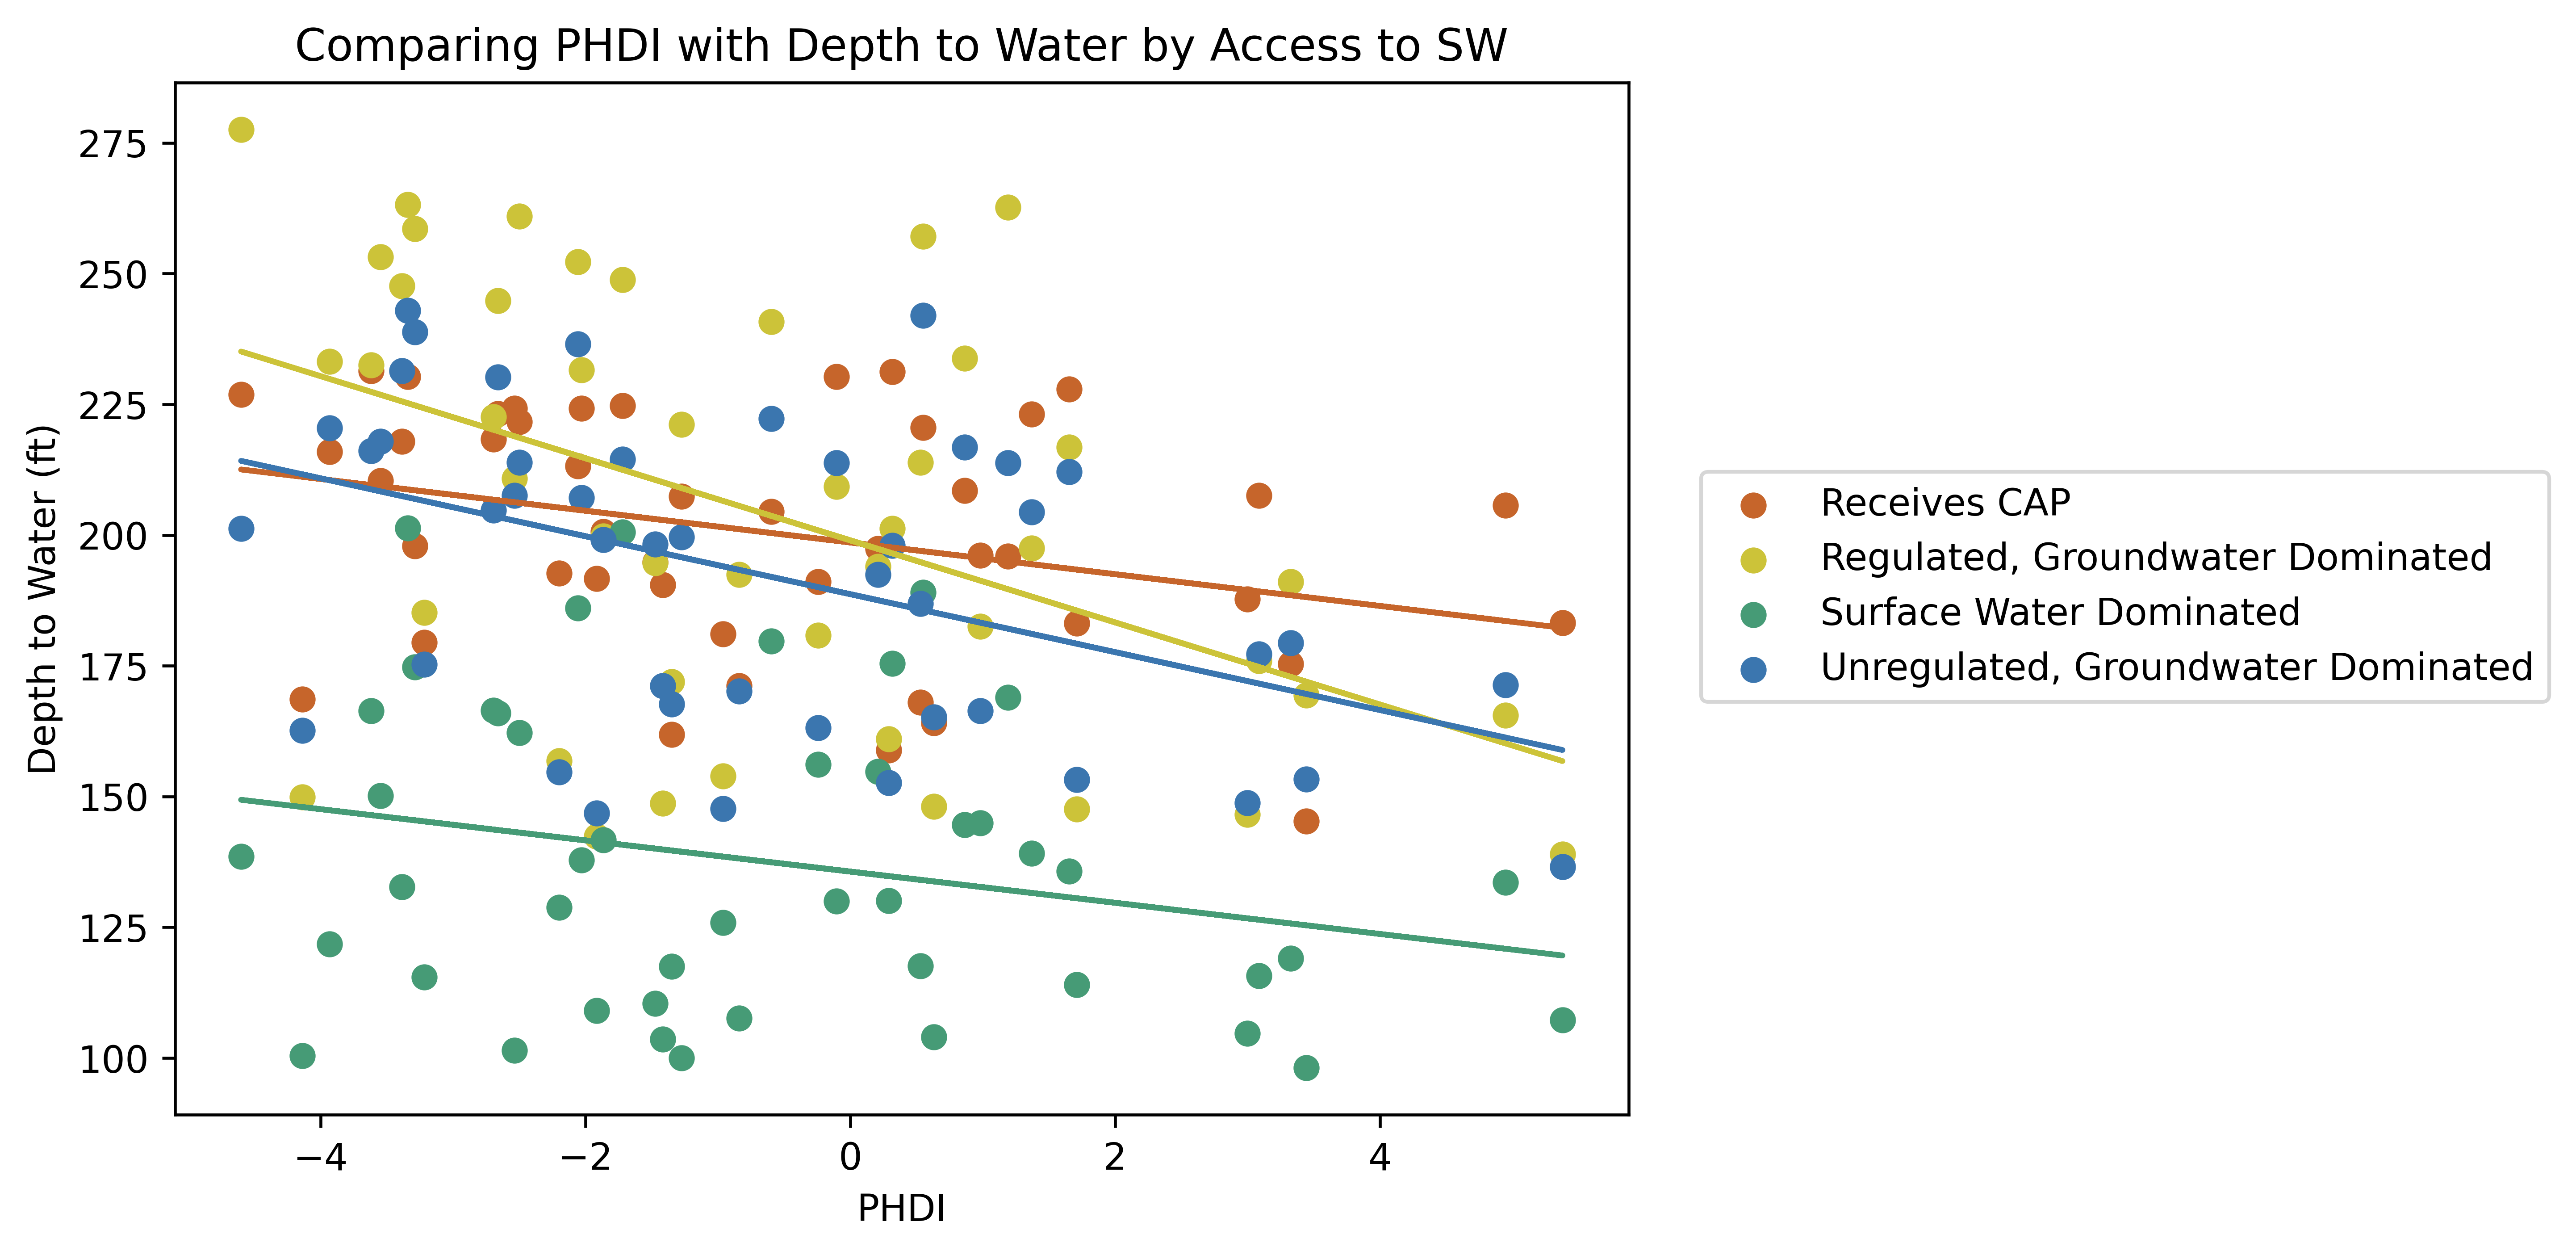

In [51]:
# %% Scatterplot of correlation values
ds = wlanalysis_period
name = 'Comparing PHDI with Depth to Water by Access to SW'
# name = 'Comparing PDSI with Depth to Water by Regulation'
# del ds['Res']
columns = ds.columns
column_list = ds.columns.tolist()
# betterlabels = ['Receives CAP (Regulated)','GW Dominated (Regulated)','Surface Water Dominated','GW Dominated','Mixed Source'] 
betterlabels = ['Receives CAP'
                ,'Regulated, Groundwater Dominated'
                ,'Surface Water Dominated'
                ,'Unregulated, Groundwater Dominated'
                # ,'Mixed \n GW/SW'
                ]
colors=[cap
        ,noCAP
        , swdom
        , GWdom
        # , mixed
        ]

fig, ax = plt.subplots(figsize = (7,5))
x = drought_indices['PDSI']
for i,j,k in zip(column_list
                # ,reg_colors
                # , SW_colors
                , colors
                , betterlabels
                ):
        y = ds[i]
        ax.scatter(x,y
                , label=k
                , color=j
                )
        # Trendline: 1=Linear, 2=polynomial
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x, p(x),'-'
                , color=j
                # ,label=(k+' Trendline')
                )


ax.set_xlabel('PHDI')
ax.set_ylabel('Depth to Water (ft)')
ax.set_title(name,loc='center')
# ax.set_ylim(0,400)
fig.set_dpi(600)
plt.legend(loc = [1.05, 0.40])

plt.savefig(outputpath+name, bbox_inches='tight') 

In [52]:
# 1. Anomaly's
ds = wlanalysis_period.copy()
columns = ds.columns
column_list = ds.columns.tolist()

dtw_anomalys = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        df = ds[i]
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)
        # print(y)
        # slope, intercept = sp.linregress(x,y) 
        dtw_anomalys[i] = wlanalysis_period[i] - ((wlanalysis_period.index*slope) + intercept)

dtw_anomalys.head()

CAP     No_CAP         SW         GW        Mix
index                                                      
1975   9.489852   4.751971  -2.817320  23.251850  31.072047
1976  -0.742255   7.300901  18.089135  -2.210931  10.230360
1977   8.942278  -6.923439  -0.054996  -5.078967  -8.469690
1978   4.180501  -5.399983  -5.865916  -5.122919  -4.651288
1979  -1.232067 -15.729300  -4.660442 -19.256845   2.902123

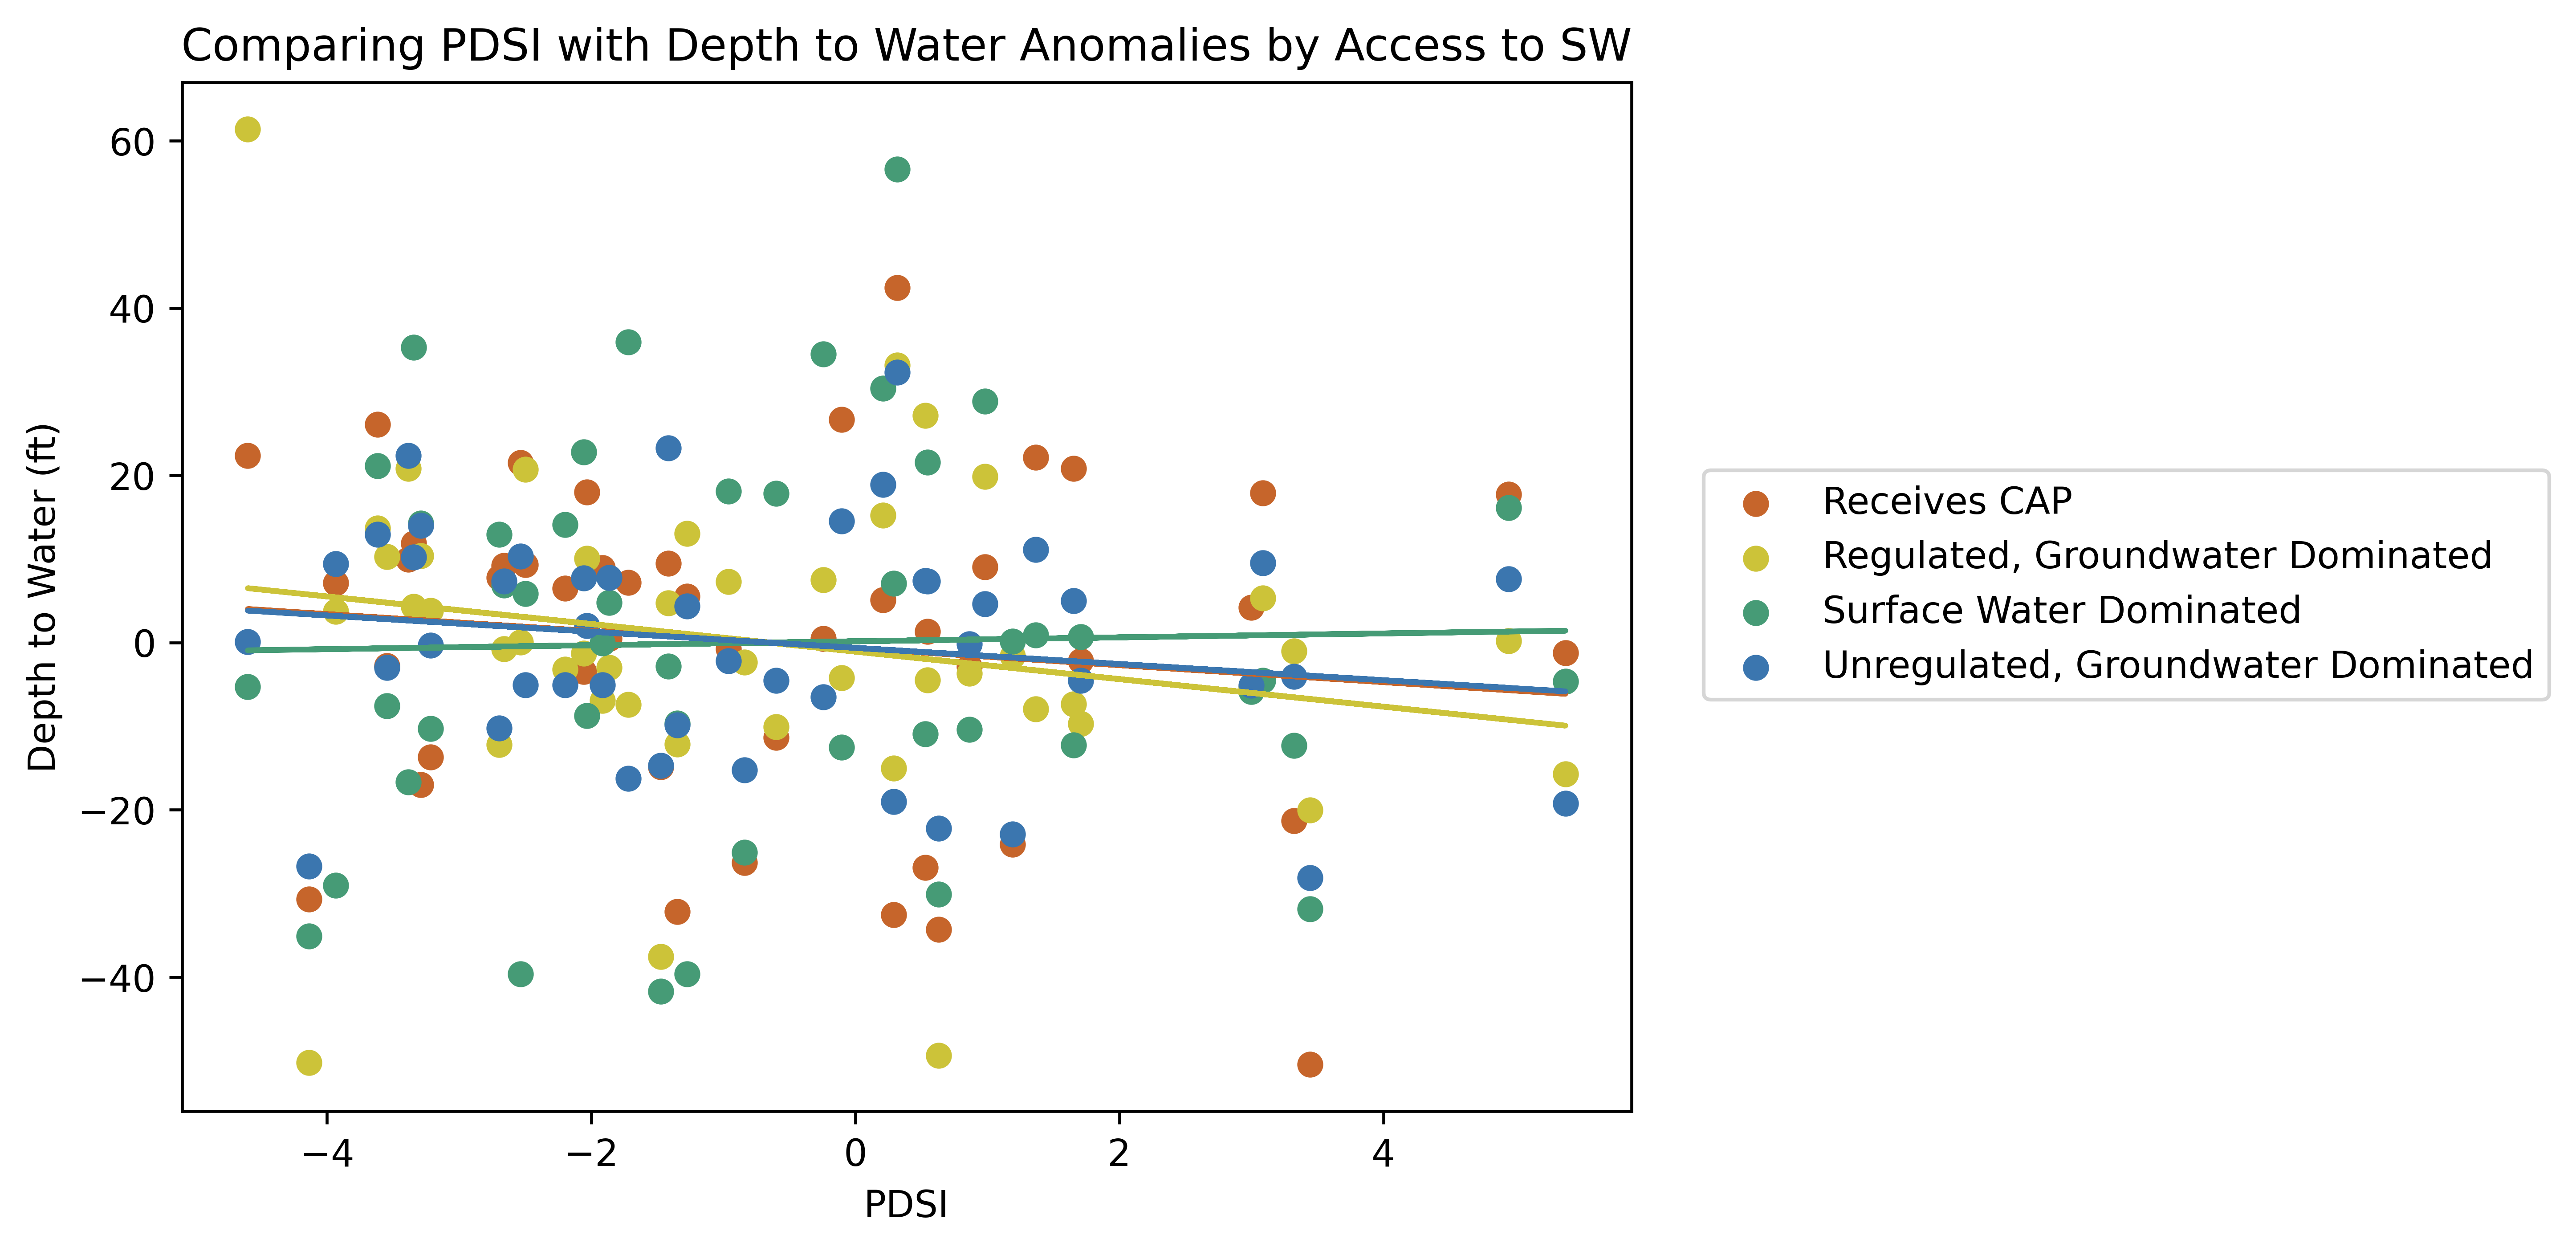

In [53]:
# %% Scatterplot of correlation values
ds = dtw_anomalys
name = 'Comparing PDSI with Depth to Water Anomalies by Access to SW'
# name = 'Comparing PDSI with Depth to Water by Regulation'
# del ds['Res']
columns = ds.columns
column_list = ds.columns.tolist()
# betterlabels = ['Receives CAP (Regulated)','GW Dominated (Regulated)','Surface Water Dominated','GW Dominated','Mixed Source'] 
betterlabels = ['Receives CAP'
                ,'Regulated, Groundwater Dominated'
                ,'Surface Water Dominated'
                ,'Unregulated, Groundwater Dominated'
                # ,'Mixed \n GW/SW'
                ]
colors=[cap
        ,noCAP
        , swdom
        , GWdom
        # , mixed
        ]

fig, ax = plt.subplots(figsize = (7,5))
x = drought_indices['PDSI']
for i,j,k in zip(column_list
                # ,reg_colors
                # , SW_colors
                , colors
                , betterlabels
                ):
        y = ds[i]
        ax.scatter(x,y
                , label=k
                , color=j
                )
        # Trendline: 1=Linear, 2=polynomial
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x, p(x),'-'
                , color=j
                # ,label=(k+' Trendline')
                )


ax.set_xlabel('PDSI')
ax.set_ylabel('Depth to Water (ft)')
ax.set_title(name,loc='center')
# ax.set_ylim(0,400)
fig.set_dpi(600)
plt.legend(loc = [1.05, 0.40])

plt.savefig(outputpath+name, bbox_inches='tight') 

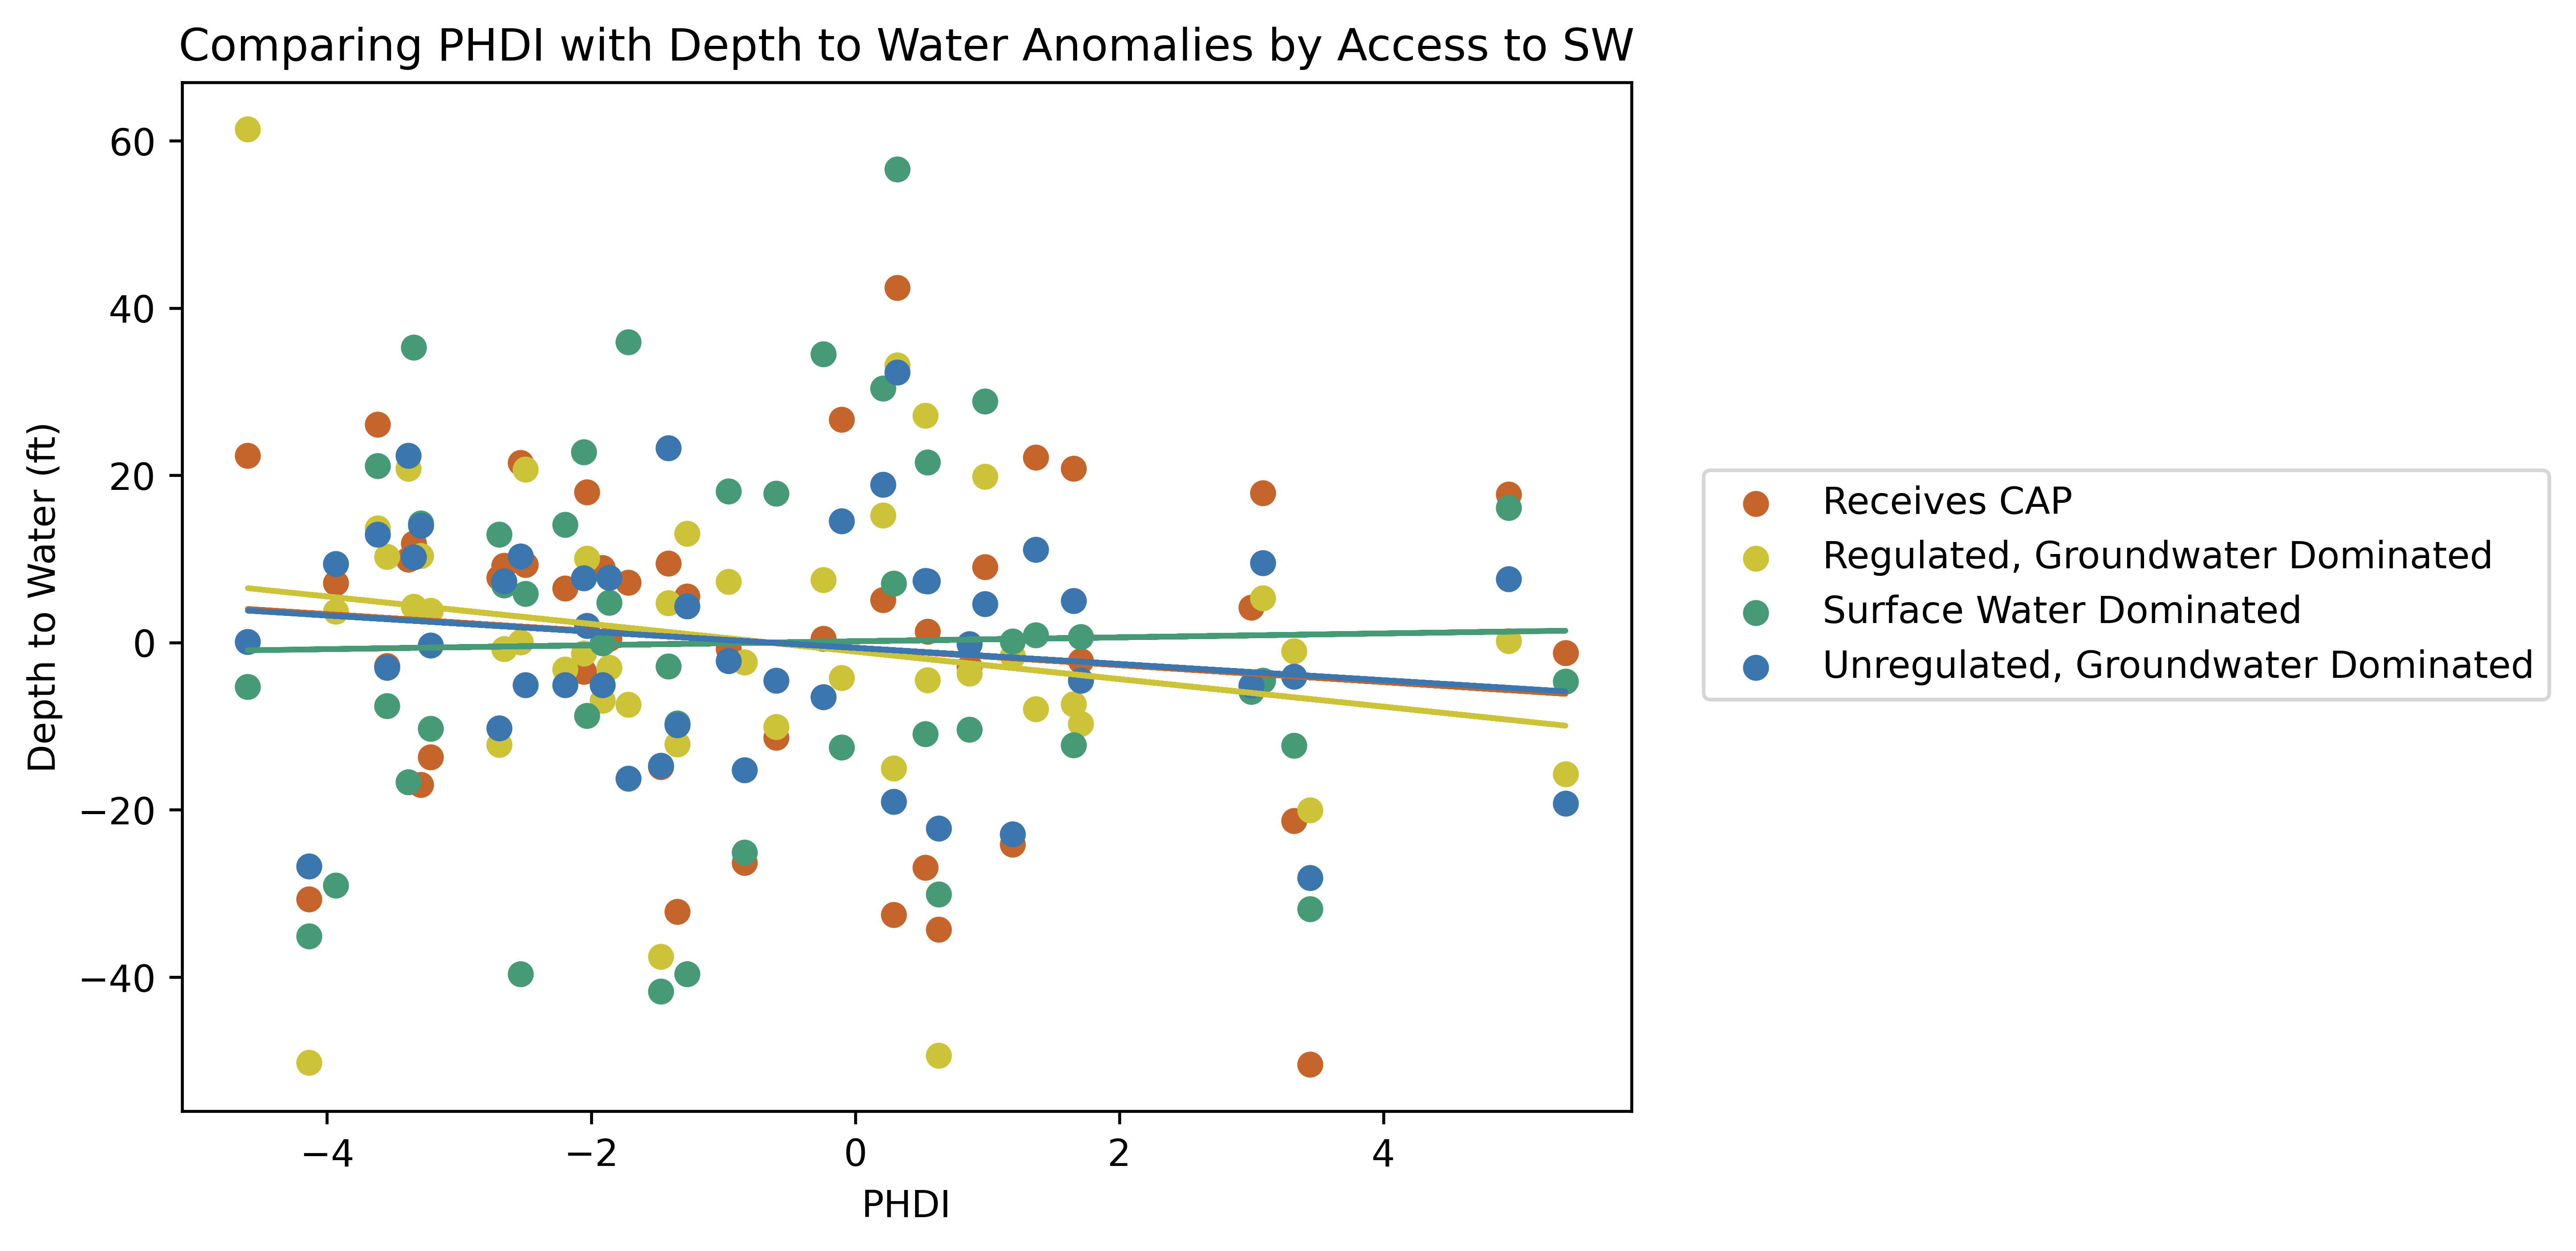

In [55]:
# %% Scatterplot of correlation values
ds = dtw_anomalys
name = 'Comparing PHDI with Depth to Water Anomalies by Access to SW'
# name = 'Comparing PDSI with Depth to Water by Regulation'
# del ds['Res']
columns = ds.columns
column_list = ds.columns.tolist()
# betterlabels = ['Receives CAP (Regulated)','GW Dominated (Regulated)','Surface Water Dominated','GW Dominated','Mixed Source'] 
betterlabels = ['Receives CAP'
                ,'Regulated, Groundwater Dominated'
                ,'Surface Water Dominated'
                ,'Unregulated, Groundwater Dominated'
                # ,'Mixed \n GW/SW'
                ]
colors=[cap
        ,noCAP
        , swdom
        , GWdom
        # , mixed
        ]

fig, ax = plt.subplots(figsize = (7,5))
x = drought_indices['PDSI']
for i,j,k in zip(column_list
                # ,reg_colors
                # , SW_colors
                , colors
                , betterlabels
                ):
        y = ds[i]
        ax.scatter(x,y
                , label=k
                , color=j
                )
        # Trendline: 1=Linear, 2=polynomial
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x, p(x),'-'
                , color=j
                # ,label=(k+' Trendline')
                )


ax.set_xlabel('PHDI')
ax.set_ylabel('Depth to Water (ft)')
ax.set_title(name,loc='center')
# ax.set_ylim(0,400)
fig.set_dpi(600)
plt.legend(loc = [1.05, 0.40])

plt.savefig(outputpath+name, bbox_inches='tight') 

In [33]:
# %% Average Anomalie for drought periods
ds = dtw_anomalys.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


dtw_mean_anomalies = ds.groupby(['Status']).mean()
dtw_mean_anomalies
# ds

CAP     No_CAP         SW         GW        Mix
Status                                                           
Drought 1  -22.941615  -4.161736  -9.974655  -5.094050 -25.930609
Drought 2  -30.694165 -50.250140 -35.115085 -26.731994 -23.333171
Drought 3   24.230759  37.525970   7.933524   6.517481  22.611832
Drought 4    8.558030  12.263032 -22.858926  15.881460   4.182702
Drought 5   -3.535056   6.641096   4.506369   6.122813   9.775500
Drought 6   11.860823   4.311152  35.300205  10.205800   4.152200
Normal-Wet   0.278405  -1.863967   1.031311  -1.041486  -0.339239

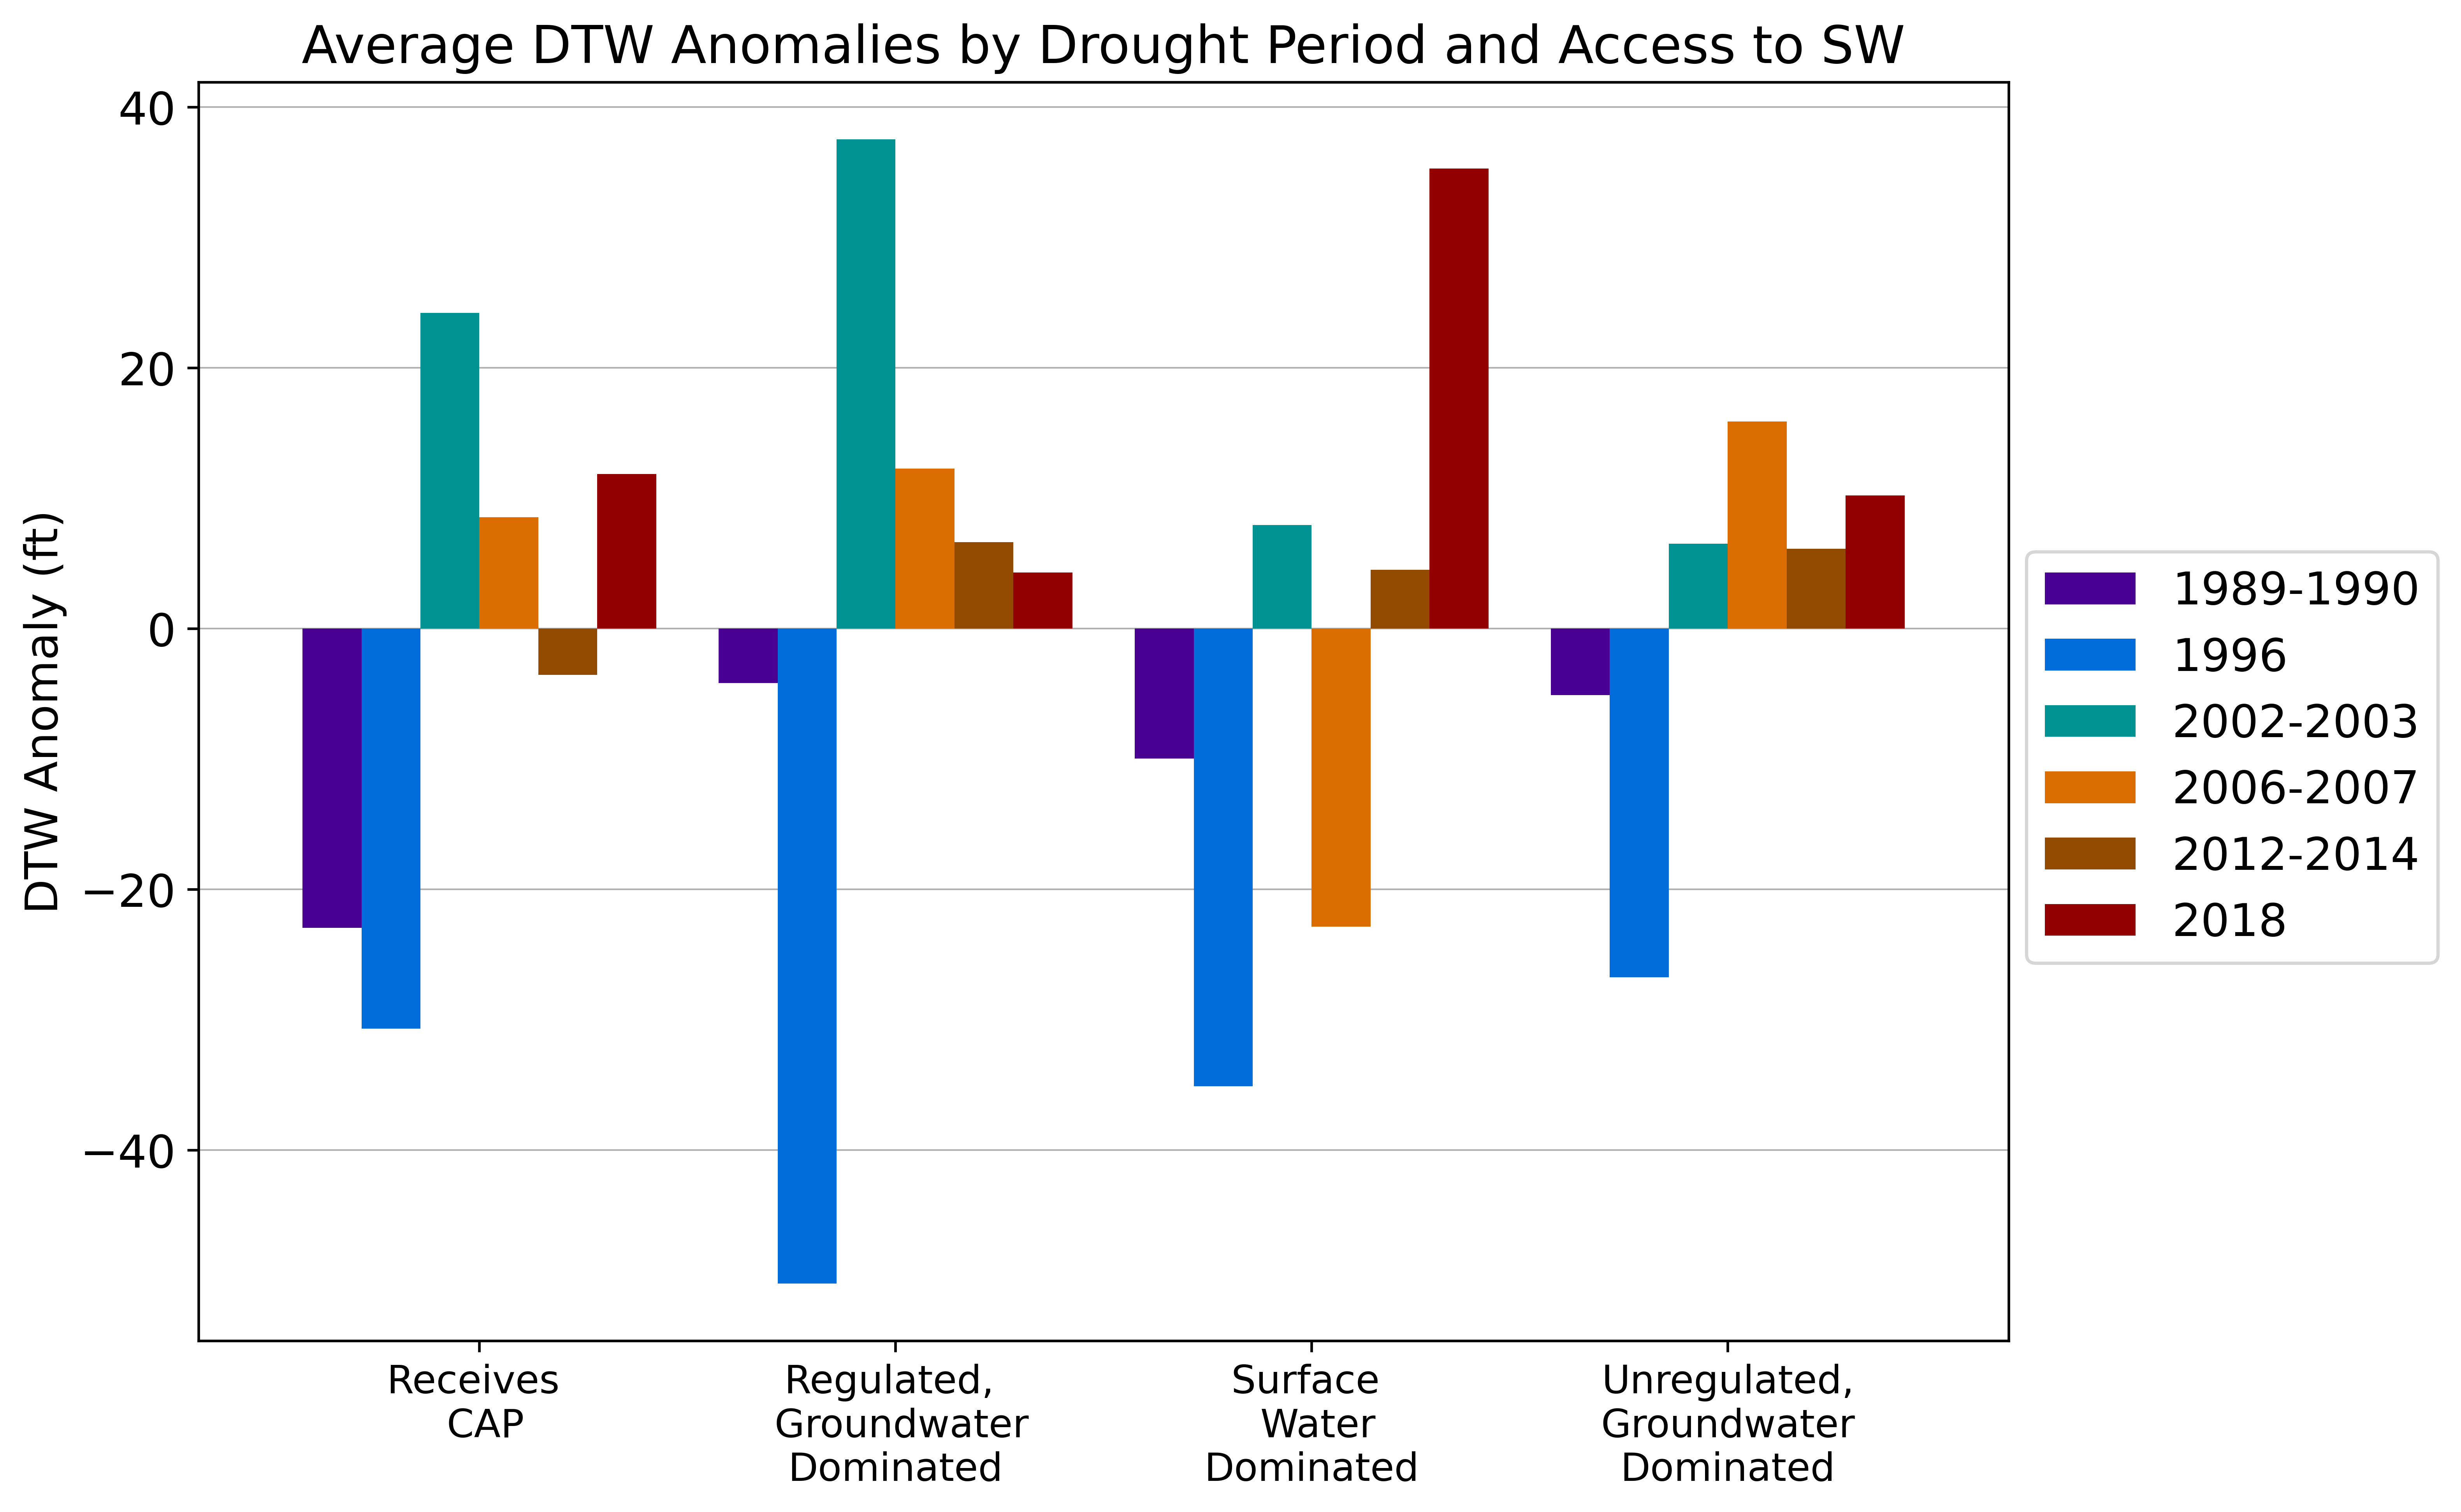

In [34]:
#%% Grouped Bar chart for drawdown (ft)
# name = 'Average DTW Anomalies by Drought Period and Groundwater Regulation'
name = 'Average DTW Anomalies by Drought Period and Access to SW'

yearlabels = ["1989-1990",'1996','2002-2003','2006-2007','2012-2014','2018','Normal/Wet Years']
betterlabels = ['Receives \n CAP'
                ,'Regulated, \n Groundwater\nDominated'
                ,'Surface \n Water\nDominated'
                ,'Unregulated,\nGroundwater\nDominated'
                # ,'Mixed \n GW/SW'
                ] 
# betterlabels = ['Regulated','Unregulated']

dtw_mean_anomalies.index = yearlabels
del dtw_mean_anomalies['Mix']
dtw_mean_anomalies = dtw_mean_anomalies.transpose()

dtw_mean_anomalies.index = betterlabels
del dtw_mean_anomalies['Normal/Wet Years']
dtw_mean_anomalies


# group_colors = ['lightsalmon','tomato','orangered','r','brown','indianred','steelblue']

group_colors = [blind[5],blind[6],blind[2]
                ,blind[12],blind[11],blind[10]
                # ,blind[0] #black
                ]

horlabel = 'DTW Anomaly (ft)'
fsize = 14

plt.rcParams["figure.dpi"] = 600
dtw_mean_anomalies.plot(figsize = (10,7),
        kind='bar',
        stacked=False,
        # title=name,
        color = group_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
plt.title(name, fontsize = (fsize+2))
# plt.ylim([0,400])
plt.ylabel(horlabel, fontsize = fsize)
plt.xticks(rotation=0, fontsize = fsize-2)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)

plt.savefig(figurepath+name+'_groupedchart', bbox_inches = 'tight')
# plt.savefig(outputpath+name+'_anomalies_SWAccess_groupedchart', bbox_inches = 'tight')

For Drawdown

In [35]:
# %% Max drawdown
ds = wlanalysis_period.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


drought_max = ds.groupby(['Status']).max()
drought_max
# ds

CAP      No_CAP          SW          GW         Mix
Status                                                                
Drought 1   179.457085  185.188335  117.531488  175.238597  104.284175
Drought 2   168.560270  149.850086  100.389946  162.618822  121.260878
Drought 3   231.442849  277.514565  166.354509  216.107231  186.951107
Drought 4   217.922892  247.637147  132.684885  231.421548  175.970707
Drought 5   223.243659  258.584721  174.755648  238.840315  204.237345
Drought 6   230.256297  263.226126  201.330124  242.929449  198.627974
Normal-Wet  231.224522  262.661556  200.566648  242.020645  244.657658

This is for calculating against the average for Normal-Wet periods

In [36]:
# Predrought values
ds = wlanalysis_period.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'

for x,y in PREDROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)

ds
predrought = ds.groupby(['Status']).mean()
predrought

CAP      No_CAP          SW          GW         Mix
Status                                                                
Drought 1   192.356553  161.694185  126.855081  160.593119  115.722992
Drought 2   164.960785  191.685594  110.591664  172.434269  121.905402
Drought 3   213.845172  207.315333  120.571103  202.663603  147.757996
Drought 4   224.208520  231.566527  137.839894  207.147709  149.745024
Drought 5   211.110092  226.396986  135.180745  214.338414  166.749471
Drought 6   208.809954  246.557291  182.885717  229.399334  216.526580
Normal-Wet  206.617611  225.551805  151.510964  207.084121  165.186791

Now for calculating against the slope

In [38]:
# Predrought values
import pandas as pd
ds = wlanalysis_period.copy()
columns = ds.columns
column_list = ds.columns.tolist()

labels = column_list
stats = pd.DataFrame()
for i in column_list:
        df = ds[i]
        # df = f[i].pct_change()
        #print(df)
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
        stats = stats._append({'slope': slope,
                               'int':intercept
                        },
                        ignore_index=True)


stats.index = labels
stats1 = stats.transpose()
stats1

CAP       No_CAP           SW           GW          Mix
slope     0.870047     2.673398     1.387495     1.971492     2.267351
int   -1537.359728 -5136.001492 -2633.934803 -3745.747980 -4381.038885

In [39]:
# Predrought values
ds = wlanalysis_period.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'

for x,y in PREDROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)

ds
# predrought = ds.groupby(['Status']).mean()
# predrought

CAP      No_CAP          SW          GW         Mix      Status
index                                                                        
1975   190.473297  148.710846  103.550318  171.201327  128.051721   Drought 1
1976   181.111237  153.933174  125.844268  147.710038  109.477386   Drought 1
1977   191.665817  142.382232  109.087632  146.813494   93.044687   Drought 1
1978   187.774087  146.579085  104.664207  148.741035   99.130440   Drought 1
1979   183.231566  138.923166  107.257176  136.578601  108.951202   Drought 1
1980   183.161669  147.605201  113.974432  153.251333  106.176942   Drought 1
1981   192.673196  156.769234  128.793260  154.702430  127.215743   Drought 1
1982   196.143852  182.536815  144.924079  166.395900  127.793003   Drought 1
1983   205.653130  165.541254  133.593669  171.346254  142.095779   Drought 1
1984   231.224522  201.202688  175.479095  198.003460  125.066920   Drought 1
1985   207.592873  175.988784  115.706086  177.213114  142.850924   Drought 1
1986   191.042024  180.853831  156.150287  163.154455   93.490920   Drought 1
1987   158.887921  160.998097  130.091541  152.599108  101.053235   Drought 1
1988   197.421395  193.936940  154.802523  192.483220  106.705082  Normal-Wet
1989   179.457085  185.188335  115.491829  175.238597  104.284175  Normal-Wet
1990   161.857944  171.934476  117.531488  167.645535  103.567139  Normal-Wet
1991   168.011749  213.876834  117.631064  186.870484  128.415536   Drought 2
1992   145.316675  169.395319   98.083428  153.336044  100.638301   Drought 2
1993   175.337702  191.063661  119.029582  179.365251  120.620907   Drought 2
1994   171.177015  192.406563  107.622582  170.165297  137.946866   Drought 2
1995   164.081089  148.077944  104.037261  165.149731  134.029894  Normal-Wet
1996   168.560270  149.850086  100.389946  162.618822  121.260878  Normal-Wet
1997   200.605432  199.768472  141.687727  199.092363  180.812892   Drought 3
1998   223.143174  197.506130  139.153187  204.403891  135.656150   Drought 3
1999   207.414494  221.143248  100.026781  199.625805  150.705464   Drought 3
2000   224.217589  210.843483  101.416717  207.532351  123.857478   Drought 3
2001   230.277415  209.253594  129.944355  213.761991  191.535229  Normal-Wet
2002   226.838155  277.514565  138.560035  201.258765  176.936221  Normal-Wet
2003   231.442849  232.491996  166.354509  216.107231  186.951107  Normal-Wet
2004   224.208520  231.566527  137.839894  207.147709  149.745024   Drought 4
2005   227.882232  216.795407  135.746060  212.084496  195.816437  Normal-Wet
2006   217.922892  247.637147  132.684885  231.421548  169.197170   Drought 5
2007   215.973031  233.230720  121.744717  220.444344  175.970707   Drought 5
2008   194.812318  194.646438  110.450053  198.293268  144.913230   Drought 5
2009   218.315766  222.637491  166.469100  204.743715  169.847968   Drought 5
2010   208.526452  233.833133  144.554973  216.789194  173.818282   Drought 5
2011   221.630756  260.927645  162.161061  213.873390  184.651494  Normal-Wet
2012   210.377478  253.166694  150.109693  217.911807  172.308850  Normal-Wet
2013   223.243659  244.815831  165.931100  230.214877  202.197362  Normal-Wet
2014   197.909407  258.584721  174.755648  238.840315  204.237345  Normal-Wet
2015   204.451166  240.842144  179.719984  222.294934  244.657658   Drought 6
2016   213.168743  252.272438  186.051450  236.503733  188.395502   Drought 6
2017   224.708918  248.851578  200.566648  214.521196  160.450923  Normal-Wet
2018   230.256297  263.226126  201.330124  242.929449  198.627974  Normal-Wet
2019   220.570143  257.103186  188.996843  242.020645  184.191474  Normal-Wet
2020   195.984295  262.661556  168.977273  213.769984  180.423860  Normal-Wet

In [40]:
# ds = predrought
predrought_slope = ds.copy()
for i in column_list:
    print(i)
    m = stats1.loc['slope',i]
    b = stats1.loc['int',i]
    x = predrought_slope[i].index*m + b
    # print(x)
    predrought_slope[i] = x
#     predrought_slope = predrought_slope._append(x)

predrought_slope
    

CAP
No_CAP
SW
GW
Mix


CAP      No_CAP          SW          GW         Mix      Status
index                                                                        
1975   180.983445  143.958875  106.367638  147.949476   96.979674   Drought 1
1976   181.853492  146.632273  107.755133  149.920969   99.247026   Drought 1
1977   182.723539  149.305671  109.142628  151.892461  101.514377   Drought 1
1978   183.593587  151.979068  110.530123  153.863954  103.781728   Drought 1
1979   184.463634  154.652466  111.917617  155.835446  106.049079   Drought 1
1980   185.333681  157.325864  113.305112  157.806938  108.316430   Drought 1
1981   186.203728  159.999261  114.692607  159.778431  110.583781   Drought 1
1982   187.073775  162.672659  116.080102  161.749923  112.851133   Drought 1
1983   187.943822  165.346056  117.467597  163.721416  115.118484   Drought 1
1984   188.813870  168.019454  118.855092  165.692908  117.385835   Drought 1
1985   189.683917  170.692852  120.242587  167.664400  119.653186   Drought 1
1986   190.553964  173.366249  121.630082  169.635893  121.920537   Drought 1
1987   191.424011  176.039647  123.017577  171.607385  124.187888   Drought 1
1988   192.294058  178.713045  124.405072  173.578877  126.455240  Normal-Wet
1989   193.164106  181.386442  125.792567  175.550370  128.722591  Normal-Wet
1990   194.034153  184.059840  127.180061  177.521862  130.989942  Normal-Wet
1991   194.904200  186.733238  128.567556  179.493355  133.257293   Drought 2
1992   195.774247  189.406635  129.955051  181.464847  135.524644   Drought 2
1993   196.644294  192.080033  131.342546  183.436339  137.791995   Drought 2
1994   197.514341  194.753431  132.730041  185.407832  140.059347   Drought 2
1995   198.384389  197.426828  134.117536  187.379324  142.326698  Normal-Wet
1996   199.254436  200.100226  135.505031  189.350816  144.594049  Normal-Wet
1997   200.124483  202.773624  136.892526  191.322309  146.861400   Drought 3
1998   200.994530  205.447021  138.280021  193.293801  149.128751   Drought 3
1999   201.864577  208.120419  139.667516  195.265294  151.396102   Drought 3
2000   202.734624  210.793817  141.055011  197.236786  153.663454   Drought 3
2001   203.604672  213.467214  142.442505  199.208278  155.930805  Normal-Wet
2002   204.474719  216.140612  143.830000  201.179771  158.198156  Normal-Wet
2003   205.344766  218.814010  145.217495  203.151263  160.465507  Normal-Wet
2004   206.214813  221.487407  146.604990  205.122756  162.732858   Drought 4
2005   207.084860  224.160805  147.992485  207.094248  165.000209  Normal-Wet
2006   207.954907  226.834203  149.379980  209.065740  167.267561   Drought 5
2007   208.824955  229.507600  150.767475  211.037233  169.534912   Drought 5
2008   209.695002  232.180998  152.154970  213.008725  171.802263   Drought 5
2009   210.565049  234.854396  153.542465  214.980217  174.069614   Drought 5
2010   211.435096  237.527793  154.929960  216.951710  176.336965   Drought 5
2011   212.305143  240.201191  156.317454  218.923202  178.604316  Normal-Wet
2012   213.175191  242.874588  157.704949  220.894695  180.871668  Normal-Wet
2013   214.045238  245.547986  159.092444  222.866187  183.139019  Normal-Wet
2014   214.915285  248.221384  160.479939  224.837679  185.406370  Normal-Wet
2015   215.785332  250.894781  161.867434  226.809172  187.673721   Drought 6
2016   216.655379  253.568179  163.254929  228.780664  189.941072   Drought 6
2017   217.525426  256.241577  164.642424  230.752157  192.208423  Normal-Wet
2018   218.395474  258.914974  166.029919  232.723649  194.475775  Normal-Wet
2019   219.265521  261.588372  167.417414  234.695141  196.743126  Normal-Wet
2020   220.135568  264.261770  168.804909  236.666634  199.010477  Normal-Wet

In [41]:
predrought = predrought_slope.groupby(['Status']).mean()
predrought

CAP      No_CAP          SW          GW         Mix
Status                                                                
Drought 1   186.203728  159.999261  114.692607  159.778431  110.583781
Drought 2   196.209271  190.743334  130.648799  182.450593  136.658320
Drought 3   201.429554  206.783720  138.973768  194.279547  150.262427
Drought 4   206.214813  221.487407  146.604990  205.122756  162.732858
Drought 5   209.695002  232.180998  152.154970  213.008725  171.802263
Drought 6   216.220356  252.231480  162.561182  227.794918  188.807397
Normal-Wet  207.494294  225.418874  148.645424  208.022009  166.067198

In [45]:
# %% Drawdown
drawdown = drought_max - predrought
# del drawdown['Status']
drawdown

CAP     No_CAP         SW         GW        Mix
Status                                                           
Drought 1   -6.746643  25.189074   2.838881  15.460166  -6.299606
Drought 2  -27.649000 -40.893248 -30.258853 -19.831771 -15.397442
Drought 3   30.013295  70.730845  27.380740  21.827684  36.688680
Drought 4   11.708078  26.149740 -13.920105  26.298793  13.237849
Drought 5   13.548657  26.403723  22.600678  25.831590  32.435082
Drought 6   14.035941  10.994646  38.768942  15.134531   9.820578
Normal-Wet  23.730228  37.242681  51.921225  33.998636  78.590460

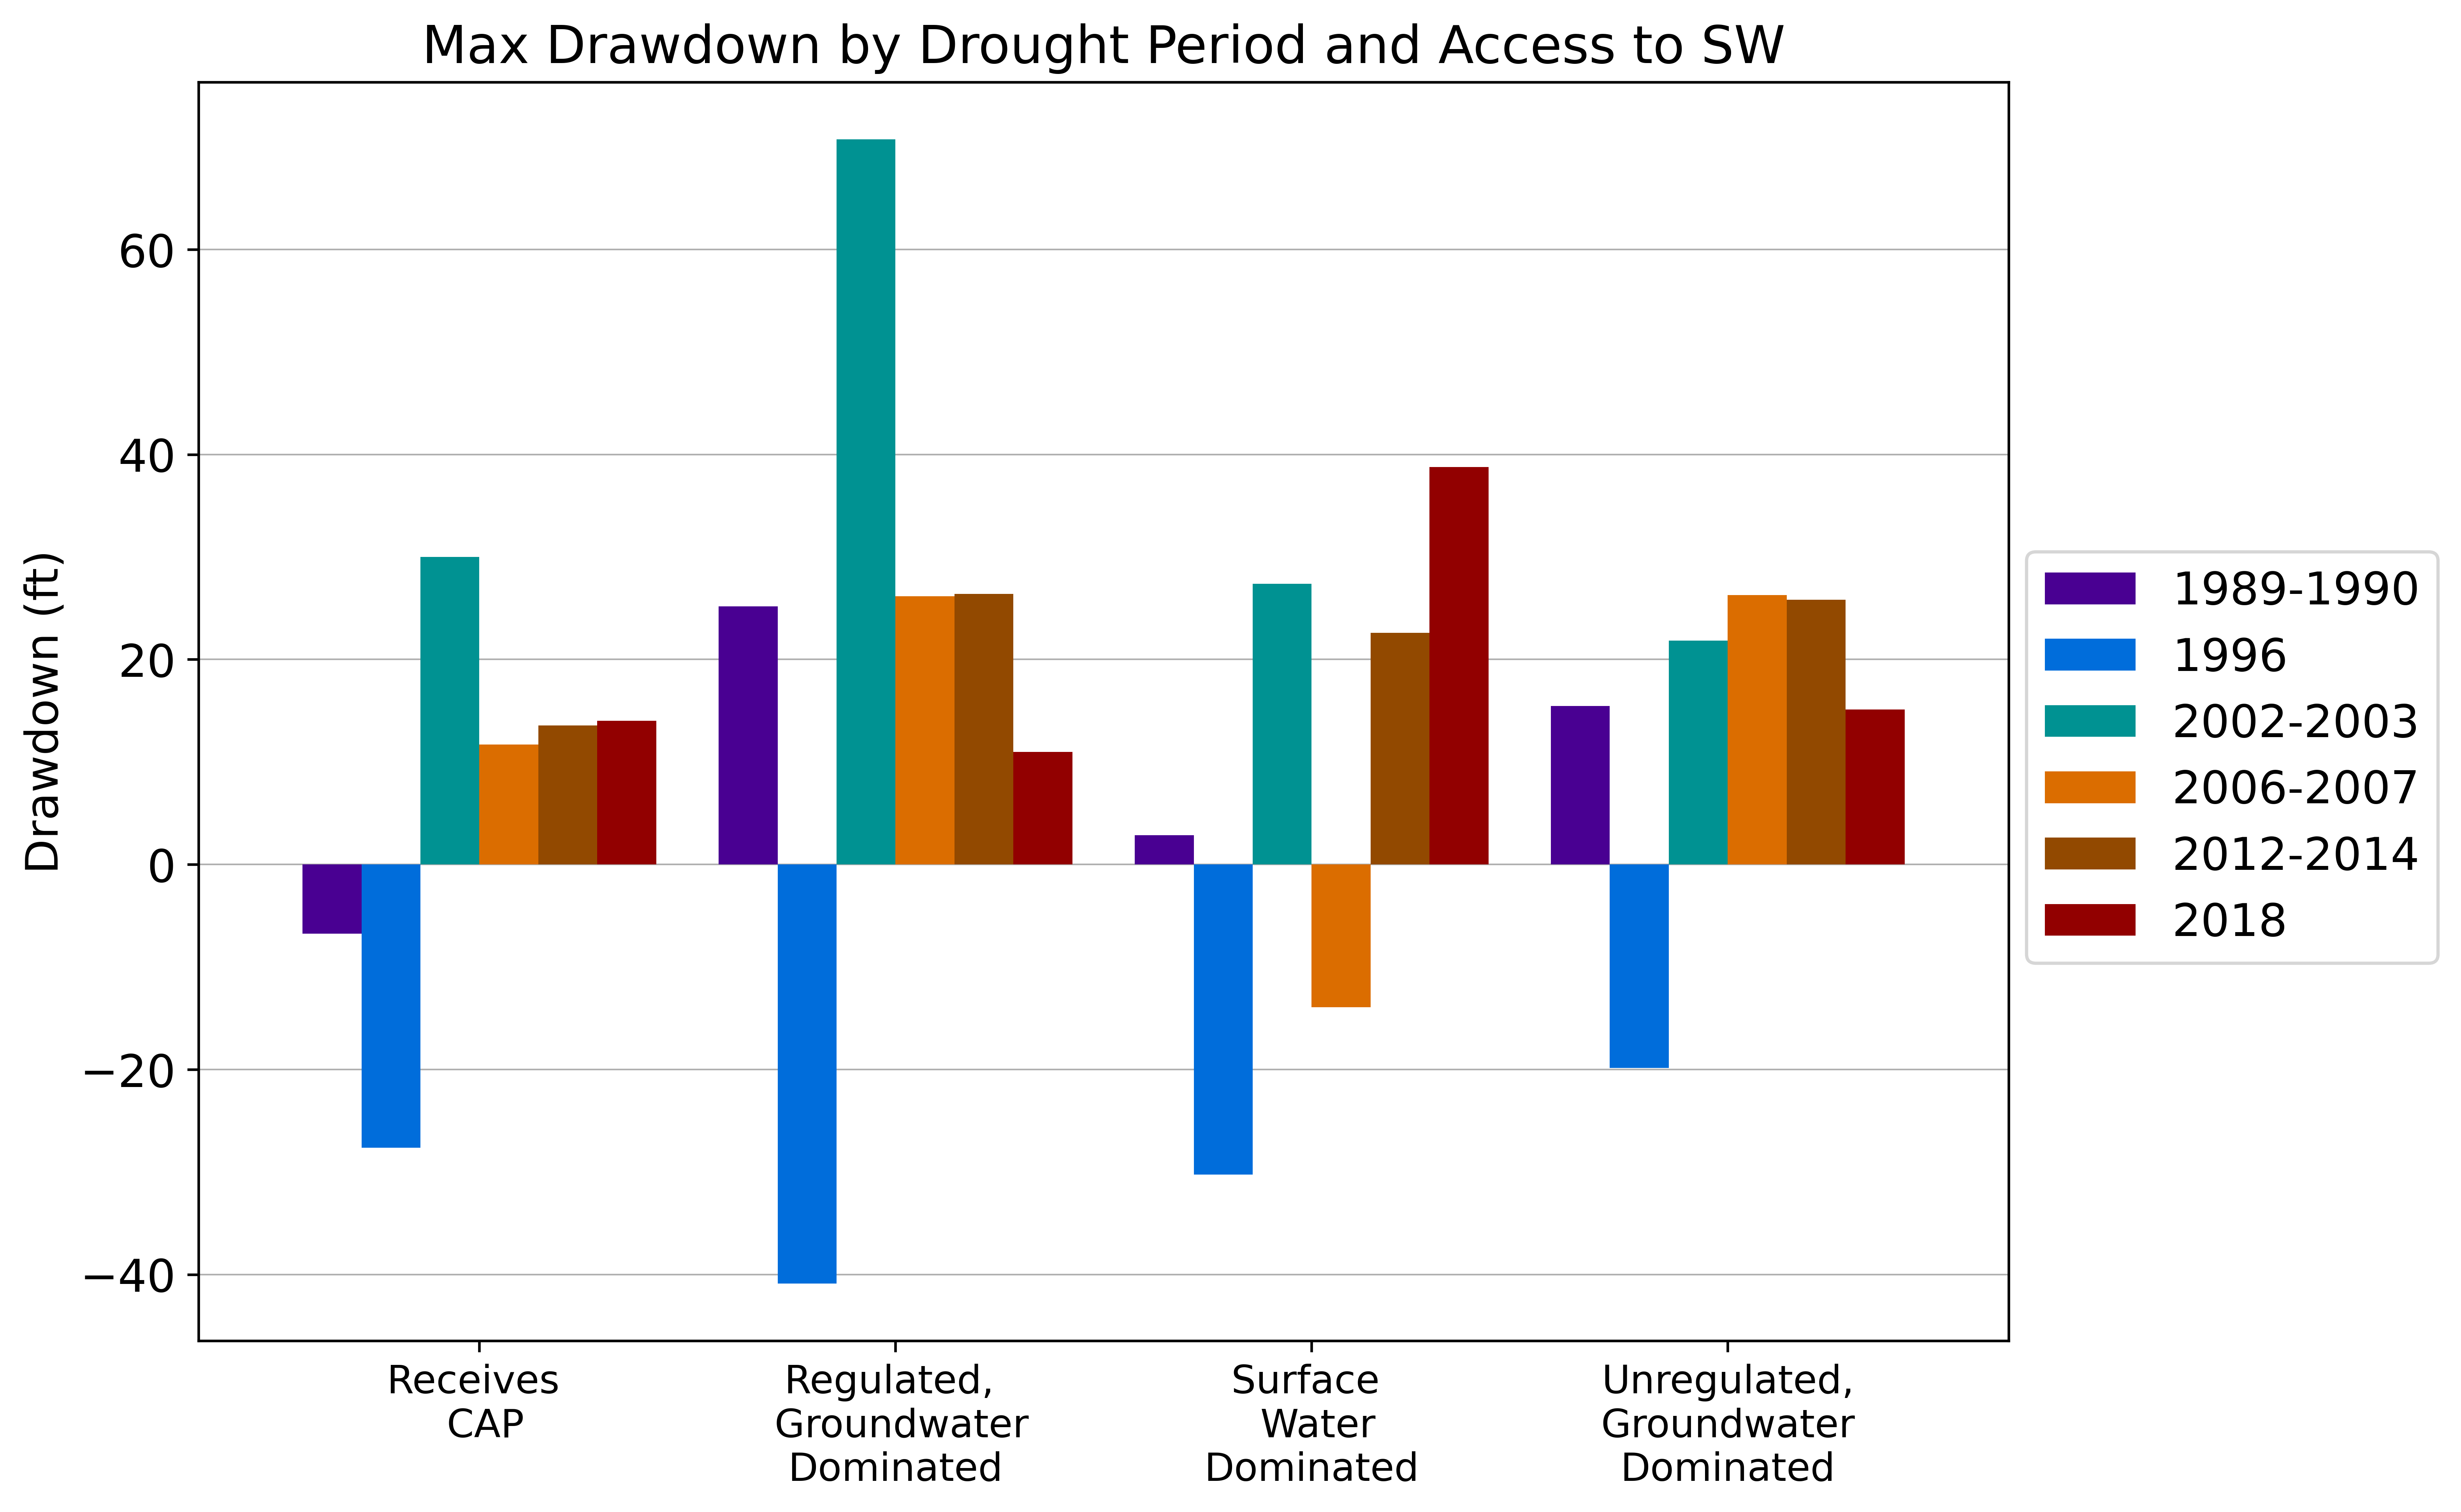

In [46]:
#%% Grouped Bar chart for drawdown (ft)
# name = 'Max Drawdown by Drought Period and Groundwater Regulation'
name = 'Max Drawdown by Drought Period and Access to SW'

yearlabels = ["1989-1990",'1996','2002-2003','2006-2007','2012-2014','2018','Normal/Wet Years']
betterlabels = ['Receives \n CAP'
                ,'Regulated, \n Groundwater\nDominated'
                ,'Surface \n Water\nDominated'
                ,'Unregulated,\nGroundwater\nDominated'
                # ,'Mixed \n GW/SW'
                ] 
# betterlabels = ['Regulated','Unregulated']

drawdown.index = yearlabels
del drawdown['Mix']
drawdown = drawdown.transpose()

drawdown.index = betterlabels
del drawdown['Normal/Wet Years']

ds = pd.DataFrame

# group_colors = ['lightsalmon','tomato','orangered','r','brown','indianred','steelblue']

group_colors = [blind[5],blind[6],blind[2]
                ,blind[12],blind[11],blind[10]
                # ,blind[0] #black
                ]

horlabel = 'Drawdown (ft)'
fsize = 14

plt.rcParams["figure.dpi"] = 600
drawdown.plot(figsize = (10,7),
        kind='bar',
        stacked=False,
        # title=name,
        color = group_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
plt.title(name, fontsize = (fsize+2))
# plt.ylim([0,400])
plt.ylabel(horlabel, fontsize = fsize)
plt.xticks(rotation=0, fontsize = fsize-2)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)

plt.savefig(figurepath+name+'_groupedchart', bbox_inches = 'tight')
# plt.savefig(outputpath+name+'_anomalies_SWAccess_groupedchart', bbox_inches = 'tight')